In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 198)
(657450, 8)
validation
(74368, 198)
(74368, 8)
test
(91684, 198)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 893832 (3.41 MB)


Trainable params: 893832 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:39 - loss: 2.4981 - STD: 0.0647 - MAE: 0.2256

 5/66 [=>............................] - ETA: 0s - loss: 1.7153 - STD: 0.1118 - MAE: 0.1846  

 9/66 [===>..........................] - ETA: 0s - loss: 1.5787 - STD: 0.1762 - MAE: 0.1563

13/66 [====>.........................] - ETA: 0s - loss: 1.5183 - STD: 0.1995 - MAE: 0.1459

17/66 [======>.......................] - ETA: 0s - loss: 1.4740 - STD: 0.2003 - MAE: 0.1448

21/66 [========>.....................] - ETA: 0s - loss: 1.4488 - STD: 0.1934 - MAE: 0.1471

25/66 [==========>...................] - ETA: 0s - loss: 1.4305 - STD: 0.1892 - MAE: 0.1484

29/66 [============>.................] - ETA: 0s - loss: 1.4147 - STD: 0.1895 - MAE: 0.1480

30/66 [============>.................] - ETA: 1s - loss: 1.4118 - STD: 0.1900 - MAE: 0.1477

34/66 [==============>...............] - ETA: 1s - loss: 1.3997 - STD: 0.1924 - MAE: 0.1465

38/66 [================>.............] - ETA: 1s - loss: 1.3913 - STD: 0.1937 - MAE: 0.1459

42/66 [==================>...........] - ETA: 0s - loss: 1.3834 - STD: 0.1933 - MAE: 0.1459

46/66 [===================>..........] - ETA: 0s - loss: 1.3771 - STD: 0.1923 - MAE: 0.1462

50/66 [=====================>........] - ETA: 0s - loss: 1.3720 - STD: 0.1916 - MAE: 0.1464

54/66 [=======================>......] - ETA: 0s - loss: 1.3674 - STD: 0.1916 - MAE: 0.1463

58/66 [=========================>....] - ETA: 0s - loss: 1.3629 - STD: 0.1920 - MAE: 0.1460

62/66 [===========================>..] - ETA: 0s - loss: 1.3583 - STD: 0.1924 - MAE: 0.1458

66/66 [==============================] - ETA: 0s - loss: 1.3557 - STD: 0.1924 - MAE: 0.1457

66/66 [==============================] - 4s 38ms/step - loss: 1.3557 - STD: 0.1924 - MAE: 0.1457 - val_loss: 1.2452 - val_STD: 0.1902 - val_MAE: 0.1426


Epoch 2/10000


 1/66 [..............................] - ETA: 1s - loss: 1.3126 - STD: 0.1902 - MAE: 0.1459

 5/66 [=>............................] - ETA: 0s - loss: 1.3069 - STD: 0.1888 - MAE: 0.1460

 9/66 [===>..........................] - ETA: 0s - loss: 1.3073 - STD: 0.1896 - MAE: 0.1458

14/66 [=====>........................] - ETA: 0s - loss: 1.3116 - STD: 0.1909 - MAE: 0.1456

18/66 [=======>......................] - ETA: 0s - loss: 1.3092 - STD: 0.1912 - MAE: 0.1454

22/66 [=========>....................] - ETA: 0s - loss: 1.3098 - STD: 0.1912 - MAE: 0.1454

26/66 [==========>...................] - ETA: 0s - loss: 1.3082 - STD: 0.1913 - MAE: 0.1453

30/66 [============>.................] - ETA: 0s - loss: 1.3091 - STD: 0.1914 - MAE: 0.1453

34/66 [==============>...............] - ETA: 0s - loss: 1.3090 - STD: 0.1915 - MAE: 0.1453

38/66 [================>.............] - ETA: 0s - loss: 1.3093 - STD: 0.1915 - MAE: 0.1453

42/66 [==================>...........] - ETA: 0s - loss: 1.3094 - STD: 0.1915 - MAE: 0.1453

46/66 [===================>..........] - ETA: 0s - loss: 1.3093 - STD: 0.1916 - MAE: 0.1452

50/66 [=====================>........] - ETA: 0s - loss: 1.3095 - STD: 0.1916 - MAE: 0.1453

54/66 [=======================>......] - ETA: 0s - loss: 1.3094 - STD: 0.1915 - MAE: 0.1453

58/66 [=========================>....] - ETA: 0s - loss: 1.3090 - STD: 0.1916 - MAE: 0.1452

62/66 [===========================>..] - ETA: 0s - loss: 1.3082 - STD: 0.1918 - MAE: 0.1451

66/66 [==============================] - ETA: 0s - loss: 1.3083 - STD: 0.1919 - MAE: 0.1451

66/66 [==============================] - 1s 14ms/step - loss: 1.3083 - STD: 0.1919 - MAE: 0.1451 - val_loss: 1.2447 - val_STD: 0.1916 - val_MAE: 0.1420


Epoch 3/10000


 1/66 [..............................] - ETA: 1s - loss: 1.3103 - STD: 0.1916 - MAE: 0.1452

 5/66 [=>............................] - ETA: 0s - loss: 1.3039 - STD: 0.1908 - MAE: 0.1453

 9/66 [===>..........................] - ETA: 0s - loss: 1.3098 - STD: 0.1911 - MAE: 0.1455

13/66 [====>.........................] - ETA: 0s - loss: 1.3123 - STD: 0.1913 - MAE: 0.1455

17/66 [======>.......................] - ETA: 0s - loss: 1.3131 - STD: 0.1912 - MAE: 0.1456

21/66 [========>.....................] - ETA: 0s - loss: 1.3107 - STD: 0.1911 - MAE: 0.1455

25/66 [==========>...................] - ETA: 0s - loss: 1.3105 - STD: 0.1914 - MAE: 0.1453

29/66 [============>.................] - ETA: 0s - loss: 1.3107 - STD: 0.1917 - MAE: 0.1453

34/66 [==============>...............] - ETA: 0s - loss: 1.3091 - STD: 0.1916 - MAE: 0.1452

38/66 [================>.............] - ETA: 0s - loss: 1.3085 - STD: 0.1918 - MAE: 0.1451

42/66 [==================>...........] - ETA: 0s - loss: 1.3083 - STD: 0.1920 - MAE: 0.1450

46/66 [===================>..........] - ETA: 0s - loss: 1.3078 - STD: 0.1920 - MAE: 0.1450

50/66 [=====================>........] - ETA: 0s - loss: 1.3080 - STD: 0.1920 - MAE: 0.1450

54/66 [=======================>......] - ETA: 0s - loss: 1.3083 - STD: 0.1919 - MAE: 0.1451

58/66 [=========================>....] - ETA: 0s - loss: 1.3086 - STD: 0.1918 - MAE: 0.1451

62/66 [===========================>..] - ETA: 0s - loss: 1.3084 - STD: 0.1919 - MAE: 0.1451

66/66 [==============================] - 1s 14ms/step - loss: 1.3083 - STD: 0.1919 - MAE: 0.1450 - val_loss: 1.2448 - val_STD: 0.1921 - val_MAE: 0.1418


Epoch 4/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2963 - STD: 0.1921 - MAE: 0.1444

 5/66 [=>............................] - ETA: 0s - loss: 1.3010 - STD: 0.1919 - MAE: 0.1447

 9/66 [===>..........................] - ETA: 0s - loss: 1.3072 - STD: 0.1920 - MAE: 0.1450

13/66 [====>.........................] - ETA: 0s - loss: 1.3059 - STD: 0.1920 - MAE: 0.1449

17/66 [======>.......................] - ETA: 0s - loss: 1.3062 - STD: 0.1922 - MAE: 0.1448

21/66 [========>.....................] - ETA: 0s - loss: 1.3047 - STD: 0.1922 - MAE: 0.1448

25/66 [==========>...................] - ETA: 0s - loss: 1.3045 - STD: 0.1924 - MAE: 0.1446

29/66 [============>.................] - ETA: 0s - loss: 1.3053 - STD: 0.1925 - MAE: 0.1447

33/66 [==============>...............] - ETA: 0s - loss: 1.3060 - STD: 0.1922 - MAE: 0.1448

37/66 [===============>..............] - ETA: 0s - loss: 1.3061 - STD: 0.1922 - MAE: 0.1448

41/66 [=================>............] - ETA: 0s - loss: 1.3068 - STD: 0.1923 - MAE: 0.1448

45/66 [===================>..........] - ETA: 0s - loss: 1.3077 - STD: 0.1921 - MAE: 0.1449

49/66 [=====================>........] - ETA: 0s - loss: 1.3074 - STD: 0.1919 - MAE: 0.1450

54/66 [=======================>......] - ETA: 0s - loss: 1.3077 - STD: 0.1921 - MAE: 0.1450

58/66 [=========================>....] - ETA: 0s - loss: 1.3074 - STD: 0.1921 - MAE: 0.1449

62/66 [===========================>..] - ETA: 0s - loss: 1.3074 - STD: 0.1920 - MAE: 0.1450

66/66 [==============================] - ETA: 0s - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450

66/66 [==============================] - 1s 14ms/step - loss: 1.3077 - STD: 0.1919 - MAE: 0.1450 - val_loss: 1.2423 - val_STD: 0.1917 - val_MAE: 0.1418


Epoch 5/10000


 1/66 [..............................] - ETA: 1s - loss: 1.3248 - STD: 0.1915 - MAE: 0.1461

 5/66 [=>............................] - ETA: 0s - loss: 1.3072 - STD: 0.1911 - MAE: 0.1453

 9/66 [===>..........................] - ETA: 0s - loss: 1.3063 - STD: 0.1920 - MAE: 0.1449

13/66 [====>.........................] - ETA: 0s - loss: 1.3050 - STD: 0.1918 - MAE: 0.1449

18/66 [=======>......................] - ETA: 0s - loss: 1.3038 - STD: 0.1920 - MAE: 0.1447

23/66 [=========>....................] - ETA: 0s - loss: 1.3030 - STD: 0.1918 - MAE: 0.1448

28/66 [===========>..................] - ETA: 0s - loss: 1.3005 - STD: 0.1919 - MAE: 0.1446

33/66 [==============>...............] - ETA: 0s - loss: 1.2992 - STD: 0.1922 - MAE: 0.1445

38/66 [================>.............] - ETA: 0s - loss: 1.2978 - STD: 0.1922 - MAE: 0.1444

43/66 [==================>...........] - ETA: 0s - loss: 1.2963 - STD: 0.1920 - MAE: 0.1444

47/66 [====================>.........] - ETA: 0s - loss: 1.2959 - STD: 0.1920 - MAE: 0.1444

51/66 [======================>.......] - ETA: 0s - loss: 1.2944 - STD: 0.1923 - MAE: 0.1442

55/66 [========================>.....] - ETA: 0s - loss: 1.2935 - STD: 0.1922 - MAE: 0.1442

60/66 [==========================>...] - ETA: 0s - loss: 1.2918 - STD: 0.1923 - MAE: 0.1441

65/66 [============================>.] - ETA: 0s - loss: 1.2899 - STD: 0.1926 - MAE: 0.1439

66/66 [==============================] - 1s 14ms/step - loss: 1.2894 - STD: 0.1927 - MAE: 0.1438 - val_loss: 1.1933 - val_STD: 0.2037 - val_MAE: 0.1351


Epoch 6/10000


 1/66 [..............................] - ETA: 2s - loss: 1.2577 - STD: 0.1968 - MAE: 0.1408

 5/66 [=>............................] - ETA: 0s - loss: 1.2650 - STD: 0.1957 - MAE: 0.1417

 9/66 [===>..........................] - ETA: 0s - loss: 1.2634 - STD: 0.1950 - MAE: 0.1419

13/66 [====>.........................] - ETA: 0s - loss: 1.2604 - STD: 0.1956 - MAE: 0.1416

17/66 [======>.......................] - ETA: 0s - loss: 1.2588 - STD: 0.1960 - MAE: 0.1414

22/66 [=========>....................] - ETA: 0s - loss: 1.2569 - STD: 0.1956 - MAE: 0.1415

26/66 [==========>...................] - ETA: 0s - loss: 1.2548 - STD: 0.1961 - MAE: 0.1412

31/66 [=============>................] - ETA: 0s - loss: 1.2531 - STD: 0.1959 - MAE: 0.1412

36/66 [===============>..............] - ETA: 0s - loss: 1.2520 - STD: 0.1961 - MAE: 0.1412

41/66 [=================>............] - ETA: 0s - loss: 1.2497 - STD: 0.1963 - MAE: 0.1410

46/66 [===================>..........] - ETA: 0s - loss: 1.2467 - STD: 0.1964 - MAE: 0.1409

51/66 [======================>.......] - ETA: 0s - loss: 1.2442 - STD: 0.1966 - MAE: 0.1407

56/66 [========================>.....] - ETA: 0s - loss: 1.2415 - STD: 0.1968 - MAE: 0.1405

61/66 [==========================>...] - ETA: 0s - loss: 1.2384 - STD: 0.1971 - MAE: 0.1403

66/66 [==============================] - ETA: 0s - loss: 1.2364 - STD: 0.1972 - MAE: 0.1402

66/66 [==============================] - 1s 14ms/step - loss: 1.2364 - STD: 0.1972 - MAE: 0.1402 - val_loss: 1.1305 - val_STD: 0.2004 - val_MAE: 0.1337


Epoch 7/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1864 - STD: 0.1971 - MAE: 0.1383

 5/66 [=>............................] - ETA: 0s - loss: 1.2047 - STD: 0.1986 - MAE: 0.1388

10/66 [===>..........................] - ETA: 0s - loss: 1.2040 - STD: 0.1997 - MAE: 0.1383

14/66 [=====>........................] - ETA: 0s - loss: 1.2030 - STD: 0.1992 - MAE: 0.1384

19/66 [=======>......................] - ETA: 0s - loss: 1.1978 - STD: 0.1993 - MAE: 0.1382

23/66 [=========>....................] - ETA: 0s - loss: 1.1954 - STD: 0.2000 - MAE: 0.1377

28/66 [===========>..................] - ETA: 0s - loss: 1.1938 - STD: 0.2003 - MAE: 0.1375

32/66 [=============>................] - ETA: 0s - loss: 1.1931 - STD: 0.2006 - MAE: 0.1374

36/66 [===============>..............] - ETA: 0s - loss: 1.1920 - STD: 0.2007 - MAE: 0.1373

40/66 [=================>............] - ETA: 0s - loss: 1.1902 - STD: 0.2010 - MAE: 0.1371

45/66 [===================>..........] - ETA: 0s - loss: 1.1896 - STD: 0.2013 - MAE: 0.1369

50/66 [=====================>........] - ETA: 0s - loss: 1.1880 - STD: 0.2014 - MAE: 0.1368

55/66 [========================>.....] - ETA: 0s - loss: 1.1877 - STD: 0.2014 - MAE: 0.1368

60/66 [==========================>...] - ETA: 0s - loss: 1.1864 - STD: 0.2017 - MAE: 0.1367

65/66 [============================>.] - ETA: 0s - loss: 1.1853 - STD: 0.2018 - MAE: 0.1366

66/66 [==============================] - 1s 14ms/step - loss: 1.1854 - STD: 0.2017 - MAE: 0.1366 - val_loss: 1.0967 - val_STD: 0.2119 - val_MAE: 0.1275


Epoch 8/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1681 - STD: 0.2026 - MAE: 0.1356

 5/66 [=>............................] - ETA: 0s - loss: 1.1686 - STD: 0.2047 - MAE: 0.1347

 9/66 [===>..........................] - ETA: 0s - loss: 1.1673 - STD: 0.2042 - MAE: 0.1349

13/66 [====>.........................] - ETA: 0s - loss: 1.1682 - STD: 0.2042 - MAE: 0.1350

18/66 [=======>......................] - ETA: 0s - loss: 1.1694 - STD: 0.2043 - MAE: 0.1350

23/66 [=========>....................] - ETA: 0s - loss: 1.1686 - STD: 0.2042 - MAE: 0.1350

28/66 [===========>..................] - ETA: 0s - loss: 1.1695 - STD: 0.2040 - MAE: 0.1352

32/66 [=============>................] - ETA: 0s - loss: 1.1696 - STD: 0.2040 - MAE: 0.1352

37/66 [===============>..............] - ETA: 0s - loss: 1.1689 - STD: 0.2041 - MAE: 0.1351

42/66 [==================>...........] - ETA: 0s - loss: 1.1688 - STD: 0.2040 - MAE: 0.1352

46/66 [===================>..........] - ETA: 0s - loss: 1.1681 - STD: 0.2042 - MAE: 0.1350

51/66 [======================>.......] - ETA: 0s - loss: 1.1677 - STD: 0.2041 - MAE: 0.1351

55/66 [========================>.....] - ETA: 0s - loss: 1.1677 - STD: 0.2042 - MAE: 0.1350

59/66 [=========================>....] - ETA: 0s - loss: 1.1673 - STD: 0.2043 - MAE: 0.1350

63/66 [===========================>..] - ETA: 0s - loss: 1.1667 - STD: 0.2042 - MAE: 0.1350

66/66 [==============================] - 1s 14ms/step - loss: 1.1665 - STD: 0.2042 - MAE: 0.1350 - val_loss: 1.0810 - val_STD: 0.2144 - val_MAE: 0.1260


Epoch 9/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1469 - STD: 0.2061 - MAE: 0.1333

 6/66 [=>............................] - ETA: 0s - loss: 1.1529 - STD: 0.2058 - MAE: 0.1338

11/66 [====>.........................] - ETA: 0s - loss: 1.1550 - STD: 0.2054 - MAE: 0.1341

15/66 [=====>........................] - ETA: 0s - loss: 1.1561 - STD: 0.2049 - MAE: 0.1344

19/66 [=======>......................] - ETA: 0s - loss: 1.1544 - STD: 0.2049 - MAE: 0.1343

23/66 [=========>....................] - ETA: 0s - loss: 1.1548 - STD: 0.2050 - MAE: 0.1343

27/66 [===========>..................] - ETA: 0s - loss: 1.1547 - STD: 0.2049 - MAE: 0.1344

31/66 [=============>................] - ETA: 0s - loss: 1.1550 - STD: 0.2051 - MAE: 0.1343

35/66 [==============>...............] - ETA: 0s - loss: 1.1540 - STD: 0.2051 - MAE: 0.1343

39/66 [================>.............] - ETA: 0s - loss: 1.1533 - STD: 0.2051 - MAE: 0.1343

43/66 [==================>...........] - ETA: 0s - loss: 1.1533 - STD: 0.2050 - MAE: 0.1343

47/66 [====================>.........] - ETA: 0s - loss: 1.1530 - STD: 0.2050 - MAE: 0.1343

51/66 [======================>.......] - ETA: 0s - loss: 1.1534 - STD: 0.2050 - MAE: 0.1343

55/66 [========================>.....] - ETA: 0s - loss: 1.1534 - STD: 0.2050 - MAE: 0.1343

59/66 [=========================>....] - ETA: 0s - loss: 1.1525 - STD: 0.2051 - MAE: 0.1342

63/66 [===========================>..] - ETA: 0s - loss: 1.1520 - STD: 0.2051 - MAE: 0.1342

66/66 [==============================] - 1s 14ms/step - loss: 1.1517 - STD: 0.2052 - MAE: 0.1342 - val_loss: 1.0616 - val_STD: 0.2108 - val_MAE: 0.1268


Epoch 10/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1435 - STD: 0.2041 - MAE: 0.1342

 6/66 [=>............................] - ETA: 0s - loss: 1.1500 - STD: 0.2037 - MAE: 0.1349

10/66 [===>..........................] - ETA: 0s - loss: 1.1460 - STD: 0.2048 - MAE: 0.1342

14/66 [=====>........................] - ETA: 0s - loss: 1.1418 - STD: 0.2053 - MAE: 0.1338

18/66 [=======>......................] - ETA: 0s - loss: 1.1371 - STD: 0.2061 - MAE: 0.1332

22/66 [=========>....................] - ETA: 0s - loss: 1.1375 - STD: 0.2060 - MAE: 0.1333

26/66 [==========>...................] - ETA: 0s - loss: 1.1371 - STD: 0.2060 - MAE: 0.1333

30/66 [============>.................] - ETA: 0s - loss: 1.1365 - STD: 0.2060 - MAE: 0.1333

34/66 [==============>...............] - ETA: 0s - loss: 1.1367 - STD: 0.2059 - MAE: 0.1333

38/66 [================>.............] - ETA: 0s - loss: 1.1365 - STD: 0.2058 - MAE: 0.1334

42/66 [==================>...........] - ETA: 0s - loss: 1.1358 - STD: 0.2060 - MAE: 0.1333

47/66 [====================>.........] - ETA: 0s - loss: 1.1348 - STD: 0.2061 - MAE: 0.1332

52/66 [======================>.......] - ETA: 0s - loss: 1.1338 - STD: 0.2063 - MAE: 0.1330

57/66 [========================>.....] - ETA: 0s - loss: 1.1322 - STD: 0.2065 - MAE: 0.1329

61/66 [==========================>...] - ETA: 0s - loss: 1.1318 - STD: 0.2066 - MAE: 0.1328

65/66 [============================>.] - ETA: 0s - loss: 1.1320 - STD: 0.2066 - MAE: 0.1328

66/66 [==============================] - 1s 14ms/step - loss: 1.1320 - STD: 0.2066 - MAE: 0.1328 - val_loss: 1.0461 - val_STD: 0.2115 - val_MAE: 0.1258


Epoch 11/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1287 - STD: 0.2055 - MAE: 0.1335

 5/66 [=>............................] - ETA: 0s - loss: 1.1389 - STD: 0.2067 - MAE: 0.1334

 9/66 [===>..........................] - ETA: 0s - loss: 1.1345 - STD: 0.2071 - MAE: 0.1329

13/66 [====>.........................] - ETA: 0s - loss: 1.1295 - STD: 0.2078 - MAE: 0.1323

17/66 [======>.......................] - ETA: 0s - loss: 1.1290 - STD: 0.2079 - MAE: 0.1322

21/66 [========>.....................] - ETA: 0s - loss: 1.1287 - STD: 0.2076 - MAE: 0.1323

25/66 [==========>...................] - ETA: 0s - loss: 1.1279 - STD: 0.2075 - MAE: 0.1323

29/66 [============>.................] - ETA: 0s - loss: 1.1267 - STD: 0.2080 - MAE: 0.1320

33/66 [==============>...............] - ETA: 0s - loss: 1.1244 - STD: 0.2082 - MAE: 0.1319

37/66 [===============>..............] - ETA: 0s - loss: 1.1243 - STD: 0.2079 - MAE: 0.1320

41/66 [=================>............] - ETA: 0s - loss: 1.1231 - STD: 0.2079 - MAE: 0.1319

45/66 [===================>..........] - ETA: 0s - loss: 1.1220 - STD: 0.2080 - MAE: 0.1319

50/66 [=====================>........] - ETA: 0s - loss: 1.1214 - STD: 0.2080 - MAE: 0.1319

55/66 [========================>.....] - ETA: 0s - loss: 1.1210 - STD: 0.2079 - MAE: 0.1319

60/66 [==========================>...] - ETA: 0s - loss: 1.1201 - STD: 0.2079 - MAE: 0.1319

64/66 [============================>.] - ETA: 0s - loss: 1.1193 - STD: 0.2081 - MAE: 0.1317

66/66 [==============================] - 1s 14ms/step - loss: 1.1188 - STD: 0.2080 - MAE: 0.1318 - val_loss: 1.0393 - val_STD: 0.2189 - val_MAE: 0.1224


Epoch 12/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1093 - STD: 0.2128 - MAE: 0.1294

 5/66 [=>............................] - ETA: 0s - loss: 1.1164 - STD: 0.2080 - MAE: 0.1317

 9/66 [===>..........................] - ETA: 0s - loss: 1.1118 - STD: 0.2085 - MAE: 0.1313

14/66 [=====>........................] - ETA: 0s - loss: 1.1129 - STD: 0.2089 - MAE: 0.1312

18/66 [=======>......................] - ETA: 0s - loss: 1.1114 - STD: 0.2093 - MAE: 0.1309

22/66 [=========>....................] - ETA: 0s - loss: 1.1100 - STD: 0.2094 - MAE: 0.1308

26/66 [==========>...................] - ETA: 0s - loss: 1.1112 - STD: 0.2090 - MAE: 0.1310

30/66 [============>.................] - ETA: 0s - loss: 1.1103 - STD: 0.2088 - MAE: 0.1311

34/66 [==============>...............] - ETA: 0s - loss: 1.1102 - STD: 0.2088 - MAE: 0.1310

38/66 [================>.............] - ETA: 0s - loss: 1.1093 - STD: 0.2090 - MAE: 0.1309

42/66 [==================>...........] - ETA: 0s - loss: 1.1075 - STD: 0.2093 - MAE: 0.1307

46/66 [===================>..........] - ETA: 0s - loss: 1.1068 - STD: 0.2092 - MAE: 0.1307

50/66 [=====================>........] - ETA: 0s - loss: 1.1065 - STD: 0.2092 - MAE: 0.1307

54/66 [=======================>......] - ETA: 0s - loss: 1.1060 - STD: 0.2092 - MAE: 0.1307

58/66 [=========================>....] - ETA: 0s - loss: 1.1058 - STD: 0.2093 - MAE: 0.1307

62/66 [===========================>..] - ETA: 0s - loss: 1.1065 - STD: 0.2093 - MAE: 0.1307

66/66 [==============================] - ETA: 0s - loss: 1.1063 - STD: 0.2094 - MAE: 0.1307

66/66 [==============================] - 1s 14ms/step - loss: 1.1063 - STD: 0.2094 - MAE: 0.1307 - val_loss: 1.0476 - val_STD: 0.2096 - val_MAE: 0.1265


Epoch 13/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0993 - STD: 0.2051 - MAE: 0.1319

 6/66 [=>............................] - ETA: 0s - loss: 1.0976 - STD: 0.2093 - MAE: 0.1303

10/66 [===>..........................] - ETA: 0s - loss: 1.0949 - STD: 0.2098 - MAE: 0.1299

14/66 [=====>........................] - ETA: 0s - loss: 1.0985 - STD: 0.2099 - MAE: 0.1301

18/66 [=======>......................] - ETA: 0s - loss: 1.0982 - STD: 0.2103 - MAE: 0.1299

22/66 [=========>....................] - ETA: 0s - loss: 1.0997 - STD: 0.2101 - MAE: 0.1300

26/66 [==========>...................] - ETA: 0s - loss: 1.1009 - STD: 0.2098 - MAE: 0.1302

30/66 [============>.................] - ETA: 0s - loss: 1.1008 - STD: 0.2099 - MAE: 0.1302

34/66 [==============>...............] - ETA: 0s - loss: 1.1012 - STD: 0.2097 - MAE: 0.1303

38/66 [================>.............] - ETA: 0s - loss: 1.1013 - STD: 0.2097 - MAE: 0.1303

42/66 [==================>...........] - ETA: 0s - loss: 1.1008 - STD: 0.2098 - MAE: 0.1303

46/66 [===================>..........] - ETA: 0s - loss: 1.0996 - STD: 0.2098 - MAE: 0.1302

50/66 [=====================>........] - ETA: 0s - loss: 1.0995 - STD: 0.2097 - MAE: 0.1302

54/66 [=======================>......] - ETA: 0s - loss: 1.0981 - STD: 0.2098 - MAE: 0.1302

58/66 [=========================>....] - ETA: 0s - loss: 1.0982 - STD: 0.2098 - MAE: 0.1302

62/66 [===========================>..] - ETA: 0s - loss: 1.0978 - STD: 0.2098 - MAE: 0.1301

66/66 [==============================] - ETA: 0s - loss: 1.0975 - STD: 0.2099 - MAE: 0.1301

66/66 [==============================] - 1s 14ms/step - loss: 1.0975 - STD: 0.2099 - MAE: 0.1301 - val_loss: 1.0295 - val_STD: 0.2157 - val_MAE: 0.1232


Epoch 14/10000


 1/66 [..............................] - ETA: 1s - loss: 1.1084 - STD: 0.2099 - MAE: 0.1305

 5/66 [=>............................] - ETA: 0s - loss: 1.0930 - STD: 0.2090 - MAE: 0.1304

 9/66 [===>..........................] - ETA: 0s - loss: 1.0918 - STD: 0.2096 - MAE: 0.1300

13/66 [====>.........................] - ETA: 0s - loss: 1.0915 - STD: 0.2097 - MAE: 0.1300

17/66 [======>.......................] - ETA: 0s - loss: 1.0931 - STD: 0.2097 - MAE: 0.1300

22/66 [=========>....................] - ETA: 0s - loss: 1.0931 - STD: 0.2099 - MAE: 0.1300

26/66 [==========>...................] - ETA: 0s - loss: 1.0913 - STD: 0.2099 - MAE: 0.1299

30/66 [============>.................] - ETA: 0s - loss: 1.0912 - STD: 0.2100 - MAE: 0.1298

34/66 [==============>...............] - ETA: 0s - loss: 1.0910 - STD: 0.2101 - MAE: 0.1298

38/66 [================>.............] - ETA: 0s - loss: 1.0895 - STD: 0.2103 - MAE: 0.1296

42/66 [==================>...........] - ETA: 0s - loss: 1.0892 - STD: 0.2103 - MAE: 0.1296

46/66 [===================>..........] - ETA: 0s - loss: 1.0890 - STD: 0.2106 - MAE: 0.1295

50/66 [=====================>........] - ETA: 0s - loss: 1.0887 - STD: 0.2106 - MAE: 0.1295

54/66 [=======================>......] - ETA: 0s - loss: 1.0893 - STD: 0.2106 - MAE: 0.1295

58/66 [=========================>....] - ETA: 0s - loss: 1.0891 - STD: 0.2107 - MAE: 0.1294

63/66 [===========================>..] - ETA: 0s - loss: 1.0886 - STD: 0.2107 - MAE: 0.1294

66/66 [==============================] - 1s 14ms/step - loss: 1.0883 - STD: 0.2107 - MAE: 0.1294 - val_loss: 1.0296 - val_STD: 0.2198 - val_MAE: 0.1216


Epoch 15/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0880 - STD: 0.2124 - MAE: 0.1291

 5/66 [=>............................] - ETA: 0s - loss: 1.0800 - STD: 0.2119 - MAE: 0.1284

 9/66 [===>..........................] - ETA: 0s - loss: 1.0815 - STD: 0.2117 - MAE: 0.1286

13/66 [====>.........................] - ETA: 0s - loss: 1.0857 - STD: 0.2112 - MAE: 0.1290

17/66 [======>.......................] - ETA: 0s - loss: 1.0870 - STD: 0.2110 - MAE: 0.1292

22/66 [=========>....................] - ETA: 0s - loss: 1.0857 - STD: 0.2111 - MAE: 0.1291

26/66 [==========>...................] - ETA: 0s - loss: 1.0860 - STD: 0.2113 - MAE: 0.1291

30/66 [============>.................] - ETA: 0s - loss: 1.0874 - STD: 0.2113 - MAE: 0.1291

34/66 [==============>...............] - ETA: 0s - loss: 1.0879 - STD: 0.2114 - MAE: 0.1291

38/66 [================>.............] - ETA: 0s - loss: 1.0878 - STD: 0.2112 - MAE: 0.1292

42/66 [==================>...........] - ETA: 0s - loss: 1.0867 - STD: 0.2111 - MAE: 0.1291

46/66 [===================>..........] - ETA: 0s - loss: 1.0868 - STD: 0.2111 - MAE: 0.1291

50/66 [=====================>........] - ETA: 0s - loss: 1.0867 - STD: 0.2113 - MAE: 0.1291

54/66 [=======================>......] - ETA: 0s - loss: 1.0872 - STD: 0.2113 - MAE: 0.1291

59/66 [=========================>....] - ETA: 0s - loss: 1.0879 - STD: 0.2112 - MAE: 0.1292

63/66 [===========================>..] - ETA: 0s - loss: 1.0877 - STD: 0.2113 - MAE: 0.1291

66/66 [==============================] - 1s 14ms/step - loss: 1.0868 - STD: 0.2114 - MAE: 0.1291 - val_loss: 1.0226 - val_STD: 0.2223 - val_MAE: 0.1202


Epoch 16/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0764 - STD: 0.2161 - MAE: 0.1261

 5/66 [=>............................] - ETA: 0s - loss: 1.0815 - STD: 0.2115 - MAE: 0.1287

 9/66 [===>..........................] - ETA: 0s - loss: 1.0845 - STD: 0.2108 - MAE: 0.1293

14/66 [=====>........................] - ETA: 0s - loss: 1.0864 - STD: 0.2108 - MAE: 0.1294

18/66 [=======>......................] - ETA: 0s - loss: 1.0861 - STD: 0.2107 - MAE: 0.1294

22/66 [=========>....................] - ETA: 0s - loss: 1.0845 - STD: 0.2106 - MAE: 0.1294

26/66 [==========>...................] - ETA: 0s - loss: 1.0839 - STD: 0.2106 - MAE: 0.1294

30/66 [============>.................] - ETA: 0s - loss: 1.0815 - STD: 0.2107 - MAE: 0.1292

34/66 [==============>...............] - ETA: 0s - loss: 1.0792 - STD: 0.2112 - MAE: 0.1289

38/66 [================>.............] - ETA: 0s - loss: 1.0793 - STD: 0.2114 - MAE: 0.1288

42/66 [==================>...........] - ETA: 0s - loss: 1.0786 - STD: 0.2116 - MAE: 0.1287

46/66 [===================>..........] - ETA: 0s - loss: 1.0779 - STD: 0.2116 - MAE: 0.1286

50/66 [=====================>........] - ETA: 0s - loss: 1.0776 - STD: 0.2116 - MAE: 0.1286

54/66 [=======================>......] - ETA: 0s - loss: 1.0773 - STD: 0.2117 - MAE: 0.1285

58/66 [=========================>....] - ETA: 0s - loss: 1.0768 - STD: 0.2118 - MAE: 0.1285

62/66 [===========================>..] - ETA: 0s - loss: 1.0765 - STD: 0.2117 - MAE: 0.1285

66/66 [==============================] - ETA: 0s - loss: 1.0766 - STD: 0.2117 - MAE: 0.1285

66/66 [==============================] - 1s 14ms/step - loss: 1.0766 - STD: 0.2117 - MAE: 0.1285 - val_loss: 1.0205 - val_STD: 0.2234 - val_MAE: 0.1197


Epoch 17/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0601 - STD: 0.2172 - MAE: 0.1253

 6/66 [=>............................] - ETA: 0s - loss: 1.0707 - STD: 0.2142 - MAE: 0.1271

11/66 [====>.........................] - ETA: 0s - loss: 1.0724 - STD: 0.2129 - MAE: 0.1278

16/66 [======>.......................] - ETA: 0s - loss: 1.0733 - STD: 0.2128 - MAE: 0.1279

20/66 [========>.....................] - ETA: 0s - loss: 1.0737 - STD: 0.2128 - MAE: 0.1279

24/66 [=========>....................] - ETA: 0s - loss: 1.0735 - STD: 0.2127 - MAE: 0.1279

28/66 [===========>..................] - ETA: 0s - loss: 1.0738 - STD: 0.2125 - MAE: 0.1280

32/66 [=============>................] - ETA: 0s - loss: 1.0732 - STD: 0.2125 - MAE: 0.1280

36/66 [===============>..............] - ETA: 0s - loss: 1.0730 - STD: 0.2124 - MAE: 0.1281

41/66 [=================>............] - ETA: 0s - loss: 1.0722 - STD: 0.2126 - MAE: 0.1279

46/66 [===================>..........] - ETA: 0s - loss: 1.0719 - STD: 0.2127 - MAE: 0.1279

50/66 [=====================>........] - ETA: 0s - loss: 1.0718 - STD: 0.2126 - MAE: 0.1279

54/66 [=======================>......] - ETA: 0s - loss: 1.0712 - STD: 0.2127 - MAE: 0.1278

58/66 [=========================>....] - ETA: 0s - loss: 1.0714 - STD: 0.2127 - MAE: 0.1279

62/66 [===========================>..] - ETA: 0s - loss: 1.0715 - STD: 0.2126 - MAE: 0.1279

66/66 [==============================] - ETA: 0s - loss: 1.0711 - STD: 0.2127 - MAE: 0.1279

66/66 [==============================] - 1s 14ms/step - loss: 1.0711 - STD: 0.2127 - MAE: 0.1279 - val_loss: 1.0125 - val_STD: 0.2168 - val_MAE: 0.1222


Epoch 18/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0786 - STD: 0.2107 - MAE: 0.1292

 6/66 [=>............................] - ETA: 0s - loss: 1.0696 - STD: 0.2119 - MAE: 0.1283

10/66 [===>..........................] - ETA: 0s - loss: 1.0678 - STD: 0.2123 - MAE: 0.1280

15/66 [=====>........................] - ETA: 0s - loss: 1.0695 - STD: 0.2130 - MAE: 0.1278

19/66 [=======>......................] - ETA: 0s - loss: 1.0688 - STD: 0.2131 - MAE: 0.1276

24/66 [=========>....................] - ETA: 0s - loss: 1.0687 - STD: 0.2133 - MAE: 0.1275

28/66 [===========>..................] - ETA: 0s - loss: 1.0678 - STD: 0.2132 - MAE: 0.1275

33/66 [==============>...............] - ETA: 0s - loss: 1.0667 - STD: 0.2132 - MAE: 0.1275

37/66 [===============>..............] - ETA: 0s - loss: 1.0673 - STD: 0.2130 - MAE: 0.1276

41/66 [=================>............] - ETA: 0s - loss: 1.0669 - STD: 0.2132 - MAE: 0.1275

45/66 [===================>..........] - ETA: 0s - loss: 1.0669 - STD: 0.2133 - MAE: 0.1275

50/66 [=====================>........] - ETA: 0s - loss: 1.0672 - STD: 0.2132 - MAE: 0.1275

54/66 [=======================>......] - ETA: 0s - loss: 1.0671 - STD: 0.2132 - MAE: 0.1275

58/66 [=========================>....] - ETA: 0s - loss: 1.0668 - STD: 0.2132 - MAE: 0.1275

62/66 [===========================>..] - ETA: 0s - loss: 1.0670 - STD: 0.2131 - MAE: 0.1275

66/66 [==============================] - 1s 14ms/step - loss: 1.0668 - STD: 0.2132 - MAE: 0.1275 - val_loss: 1.0159 - val_STD: 0.2260 - val_MAE: 0.1186


Epoch 19/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0540 - STD: 0.2205 - MAE: 0.1236

 6/66 [=>............................] - ETA: 0s - loss: 1.0539 - STD: 0.2151 - MAE: 0.1260

11/66 [====>.........................] - ETA: 0s - loss: 1.0607 - STD: 0.2142 - MAE: 0.1268

16/66 [======>.......................] - ETA: 0s - loss: 1.0616 - STD: 0.2139 - MAE: 0.1270

21/66 [========>.....................] - ETA: 0s - loss: 1.0635 - STD: 0.2140 - MAE: 0.1270

25/66 [==========>...................] - ETA: 0s - loss: 1.0629 - STD: 0.2137 - MAE: 0.1271

30/66 [============>.................] - ETA: 0s - loss: 1.0620 - STD: 0.2140 - MAE: 0.1269

34/66 [==============>...............] - ETA: 0s - loss: 1.0620 - STD: 0.2139 - MAE: 0.1270

38/66 [================>.............] - ETA: 0s - loss: 1.0627 - STD: 0.2138 - MAE: 0.1271

43/66 [==================>...........] - ETA: 0s - loss: 1.0628 - STD: 0.2137 - MAE: 0.1271

48/66 [====================>.........] - ETA: 0s - loss: 1.0626 - STD: 0.2137 - MAE: 0.1271

52/66 [======================>.......] - ETA: 0s - loss: 1.0623 - STD: 0.2138 - MAE: 0.1270

56/66 [========================>.....] - ETA: 0s - loss: 1.0625 - STD: 0.2139 - MAE: 0.1270

60/66 [==========================>...] - ETA: 0s - loss: 1.0626 - STD: 0.2138 - MAE: 0.1271

64/66 [============================>.] - ETA: 0s - loss: 1.0623 - STD: 0.2137 - MAE: 0.1271

66/66 [==============================] - 1s 14ms/step - loss: 1.0624 - STD: 0.2138 - MAE: 0.1271 - val_loss: 1.0145 - val_STD: 0.2193 - val_MAE: 0.1214


Epoch 20/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0483 - STD: 0.2139 - MAE: 0.1260

 5/66 [=>............................] - ETA: 0s - loss: 1.0580 - STD: 0.2143 - MAE: 0.1266

 9/66 [===>..........................] - ETA: 0s - loss: 1.0576 - STD: 0.2141 - MAE: 0.1266

13/66 [====>.........................] - ETA: 0s - loss: 1.0577 - STD: 0.2141 - MAE: 0.1267

17/66 [======>.......................] - ETA: 0s - loss: 1.0576 - STD: 0.2145 - MAE: 0.1265

21/66 [========>.....................] - ETA: 0s - loss: 1.0579 - STD: 0.2142 - MAE: 0.1267

25/66 [==========>...................] - ETA: 0s - loss: 1.0583 - STD: 0.2141 - MAE: 0.1268

29/66 [============>.................] - ETA: 0s - loss: 1.0573 - STD: 0.2140 - MAE: 0.1268

33/66 [==============>...............] - ETA: 0s - loss: 1.0574 - STD: 0.2140 - MAE: 0.1268

38/66 [================>.............] - ETA: 0s - loss: 1.0574 - STD: 0.2140 - MAE: 0.1268

42/66 [==================>...........] - ETA: 0s - loss: 1.0570 - STD: 0.2140 - MAE: 0.1268

46/66 [===================>..........] - ETA: 0s - loss: 1.0568 - STD: 0.2141 - MAE: 0.1268

50/66 [=====================>........] - ETA: 0s - loss: 1.0569 - STD: 0.2140 - MAE: 0.1268

54/66 [=======================>......] - ETA: 0s - loss: 1.0565 - STD: 0.2140 - MAE: 0.1268

58/66 [=========================>....] - ETA: 0s - loss: 1.0565 - STD: 0.2141 - MAE: 0.1267

62/66 [===========================>..] - ETA: 0s - loss: 1.0563 - STD: 0.2141 - MAE: 0.1267

66/66 [==============================] - ETA: 0s - loss: 1.0565 - STD: 0.2142 - MAE: 0.1267

66/66 [==============================] - 1s 14ms/step - loss: 1.0565 - STD: 0.2142 - MAE: 0.1267 - val_loss: 1.0261 - val_STD: 0.2198 - val_MAE: 0.1217


Epoch 21/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0469 - STD: 0.2150 - MAE: 0.1258

 5/66 [=>............................] - ETA: 0s - loss: 1.0534 - STD: 0.2153 - MAE: 0.1261

 9/66 [===>..........................] - ETA: 0s - loss: 1.0543 - STD: 0.2145 - MAE: 0.1265

14/66 [=====>........................] - ETA: 0s - loss: 1.0532 - STD: 0.2148 - MAE: 0.1264

18/66 [=======>......................] - ETA: 0s - loss: 1.0550 - STD: 0.2147 - MAE: 0.1265

22/66 [=========>....................] - ETA: 0s - loss: 1.0567 - STD: 0.2145 - MAE: 0.1266

26/66 [==========>...................] - ETA: 0s - loss: 1.0567 - STD: 0.2144 - MAE: 0.1267

30/66 [============>.................] - ETA: 0s - loss: 1.0569 - STD: 0.2141 - MAE: 0.1268

35/66 [==============>...............] - ETA: 0s - loss: 1.0559 - STD: 0.2144 - MAE: 0.1266

39/66 [================>.............] - ETA: 0s - loss: 1.0557 - STD: 0.2144 - MAE: 0.1266

44/66 [===================>..........] - ETA: 0s - loss: 1.0553 - STD: 0.2143 - MAE: 0.1266

48/66 [====================>.........] - ETA: 0s - loss: 1.0550 - STD: 0.2144 - MAE: 0.1266

52/66 [======================>.......] - ETA: 0s - loss: 1.0551 - STD: 0.2144 - MAE: 0.1266

56/66 [========================>.....] - ETA: 0s - loss: 1.0548 - STD: 0.2144 - MAE: 0.1266

60/66 [==========================>...] - ETA: 0s - loss: 1.0548 - STD: 0.2144 - MAE: 0.1266

65/66 [============================>.] - ETA: 0s - loss: 1.0547 - STD: 0.2145 - MAE: 0.1265

66/66 [==============================] - 1s 14ms/step - loss: 1.0547 - STD: 0.2145 - MAE: 0.1265 - val_loss: 1.0323 - val_STD: 0.2131 - val_MAE: 0.1247


Epoch 22/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0626 - STD: 0.2085 - MAE: 0.1294

 5/66 [=>............................] - ETA: 0s - loss: 1.0608 - STD: 0.2126 - MAE: 0.1276

 9/66 [===>..........................] - ETA: 0s - loss: 1.0575 - STD: 0.2133 - MAE: 0.1272

13/66 [====>.........................] - ETA: 0s - loss: 1.0546 - STD: 0.2139 - MAE: 0.1268

17/66 [======>.......................] - ETA: 0s - loss: 1.0548 - STD: 0.2140 - MAE: 0.1268

21/66 [========>.....................] - ETA: 0s - loss: 1.0517 - STD: 0.2143 - MAE: 0.1265

26/66 [==========>...................] - ETA: 0s - loss: 1.0512 - STD: 0.2144 - MAE: 0.1264

31/66 [=============>................] - ETA: 0s - loss: 1.0502 - STD: 0.2143 - MAE: 0.1264

35/66 [==============>...............] - ETA: 0s - loss: 1.0510 - STD: 0.2145 - MAE: 0.1263

39/66 [================>.............] - ETA: 0s - loss: 1.0511 - STD: 0.2145 - MAE: 0.1263

43/66 [==================>...........] - ETA: 0s - loss: 1.0511 - STD: 0.2145 - MAE: 0.1264

47/66 [====================>.........] - ETA: 0s - loss: 1.0507 - STD: 0.2145 - MAE: 0.1263

51/66 [======================>.......] - ETA: 0s - loss: 1.0506 - STD: 0.2146 - MAE: 0.1263

55/66 [========================>.....] - ETA: 0s - loss: 1.0502 - STD: 0.2147 - MAE: 0.1262

59/66 [=========================>....] - ETA: 0s - loss: 1.0505 - STD: 0.2148 - MAE: 0.1262

63/66 [===========================>..] - ETA: 0s - loss: 1.0492 - STD: 0.2149 - MAE: 0.1261

66/66 [==============================] - 1s 14ms/step - loss: 1.0496 - STD: 0.2148 - MAE: 0.1261 - val_loss: 1.0101 - val_STD: 0.2216 - val_MAE: 0.1203


Epoch 23/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0461 - STD: 0.2159 - MAE: 0.1256

 5/66 [=>............................] - ETA: 0s - loss: 1.0472 - STD: 0.2147 - MAE: 0.1260

 9/66 [===>..........................] - ETA: 0s - loss: 1.0466 - STD: 0.2159 - MAE: 0.1255

14/66 [=====>........................] - ETA: 0s - loss: 1.0508 - STD: 0.2156 - MAE: 0.1258

18/66 [=======>......................] - ETA: 0s - loss: 1.0499 - STD: 0.2155 - MAE: 0.1258

22/66 [=========>....................] - ETA: 0s - loss: 1.0496 - STD: 0.2154 - MAE: 0.1258

26/66 [==========>...................] - ETA: 0s - loss: 1.0486 - STD: 0.2154 - MAE: 0.1258

30/66 [============>.................] - ETA: 0s - loss: 1.0487 - STD: 0.2154 - MAE: 0.1258

34/66 [==============>...............] - ETA: 0s - loss: 1.0488 - STD: 0.2153 - MAE: 0.1259

38/66 [================>.............] - ETA: 0s - loss: 1.0492 - STD: 0.2150 - MAE: 0.1260

42/66 [==================>...........] - ETA: 0s - loss: 1.0490 - STD: 0.2149 - MAE: 0.1261

46/66 [===================>..........] - ETA: 0s - loss: 1.0489 - STD: 0.2149 - MAE: 0.1261

50/66 [=====================>........] - ETA: 0s - loss: 1.0486 - STD: 0.2149 - MAE: 0.1261

54/66 [=======================>......] - ETA: 0s - loss: 1.0484 - STD: 0.2150 - MAE: 0.1260

58/66 [=========================>....] - ETA: 0s - loss: 1.0481 - STD: 0.2150 - MAE: 0.1260

63/66 [===========================>..] - ETA: 0s - loss: 1.0473 - STD: 0.2151 - MAE: 0.1259

66/66 [==============================] - 1s 14ms/step - loss: 1.0474 - STD: 0.2151 - MAE: 0.1259 - val_loss: 1.0081 - val_STD: 0.2230 - val_MAE: 0.1196


Epoch 24/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0550 - STD: 0.2164 - MAE: 0.1258

 5/66 [=>............................] - ETA: 0s - loss: 1.0522 - STD: 0.2137 - MAE: 0.1269

 9/66 [===>..........................] - ETA: 0s - loss: 1.0471 - STD: 0.2147 - MAE: 0.1261

14/66 [=====>........................] - ETA: 0s - loss: 1.0457 - STD: 0.2150 - MAE: 0.1260

18/66 [=======>......................] - ETA: 0s - loss: 1.0442 - STD: 0.2149 - MAE: 0.1259

23/66 [=========>....................] - ETA: 0s - loss: 1.0424 - STD: 0.2153 - MAE: 0.1256

27/66 [===========>..................] - ETA: 0s - loss: 1.0417 - STD: 0.2155 - MAE: 0.1255

31/66 [=============>................] - ETA: 0s - loss: 1.0414 - STD: 0.2153 - MAE: 0.1256

35/66 [==============>...............] - ETA: 0s - loss: 1.0414 - STD: 0.2154 - MAE: 0.1255

40/66 [=================>............] - ETA: 0s - loss: 1.0412 - STD: 0.2154 - MAE: 0.1255

44/66 [===================>..........] - ETA: 0s - loss: 1.0420 - STD: 0.2156 - MAE: 0.1255

49/66 [=====================>........] - ETA: 0s - loss: 1.0423 - STD: 0.2154 - MAE: 0.1256

54/66 [=======================>......] - ETA: 0s - loss: 1.0422 - STD: 0.2155 - MAE: 0.1256

59/66 [=========================>....] - ETA: 0s - loss: 1.0419 - STD: 0.2155 - MAE: 0.1255

64/66 [============================>.] - ETA: 0s - loss: 1.0420 - STD: 0.2156 - MAE: 0.1255

66/66 [==============================] - 1s 14ms/step - loss: 1.0424 - STD: 0.2155 - MAE: 0.1255 - val_loss: 1.0155 - val_STD: 0.2178 - val_MAE: 0.1221


Epoch 25/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0369 - STD: 0.2144 - MAE: 0.1255

 6/66 [=>............................] - ETA: 0s - loss: 1.0451 - STD: 0.2152 - MAE: 0.1259

11/66 [====>.........................] - ETA: 0s - loss: 1.0443 - STD: 0.2149 - MAE: 0.1259

15/66 [=====>........................] - ETA: 0s - loss: 1.0410 - STD: 0.2154 - MAE: 0.1255

19/66 [=======>......................] - ETA: 0s - loss: 1.0411 - STD: 0.2153 - MAE: 0.1255

23/66 [=========>....................] - ETA: 0s - loss: 1.0411 - STD: 0.2154 - MAE: 0.1255

27/66 [===========>..................] - ETA: 0s - loss: 1.0408 - STD: 0.2157 - MAE: 0.1253

31/66 [=============>................] - ETA: 0s - loss: 1.0408 - STD: 0.2157 - MAE: 0.1253

35/66 [==============>...............] - ETA: 0s - loss: 1.0413 - STD: 0.2159 - MAE: 0.1253

39/66 [================>.............] - ETA: 0s - loss: 1.0430 - STD: 0.2157 - MAE: 0.1255

43/66 [==================>...........] - ETA: 0s - loss: 1.0427 - STD: 0.2156 - MAE: 0.1255

47/66 [====================>.........] - ETA: 0s - loss: 1.0435 - STD: 0.2154 - MAE: 0.1256

51/66 [======================>.......] - ETA: 0s - loss: 1.0437 - STD: 0.2154 - MAE: 0.1256

55/66 [========================>.....] - ETA: 0s - loss: 1.0446 - STD: 0.2155 - MAE: 0.1256

59/66 [=========================>....] - ETA: 0s - loss: 1.0440 - STD: 0.2155 - MAE: 0.1256

63/66 [===========================>..] - ETA: 0s - loss: 1.0440 - STD: 0.2156 - MAE: 0.1256

66/66 [==============================] - 1s 14ms/step - loss: 1.0438 - STD: 0.2155 - MAE: 0.1256 - val_loss: 1.0234 - val_STD: 0.2222 - val_MAE: 0.1205


Epoch 26/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0404 - STD: 0.2165 - MAE: 0.1249

 5/66 [=>............................] - ETA: 0s - loss: 1.0449 - STD: 0.2140 - MAE: 0.1263

 9/66 [===>..........................] - ETA: 0s - loss: 1.0437 - STD: 0.2144 - MAE: 0.1261

13/66 [====>.........................] - ETA: 0s - loss: 1.0457 - STD: 0.2151 - MAE: 0.1259

18/66 [=======>......................] - ETA: 0s - loss: 1.0456 - STD: 0.2147 - MAE: 0.1260

22/66 [=========>....................] - ETA: 0s - loss: 1.0442 - STD: 0.2151 - MAE: 0.1258

26/66 [==========>...................] - ETA: 0s - loss: 1.0427 - STD: 0.2157 - MAE: 0.1255

30/66 [============>.................] - ETA: 0s - loss: 1.0423 - STD: 0.2158 - MAE: 0.1254

34/66 [==============>...............] - ETA: 0s - loss: 1.0420 - STD: 0.2158 - MAE: 0.1254

38/66 [================>.............] - ETA: 0s - loss: 1.0414 - STD: 0.2157 - MAE: 0.1254

43/66 [==================>...........] - ETA: 0s - loss: 1.0410 - STD: 0.2157 - MAE: 0.1254

47/66 [====================>.........] - ETA: 0s - loss: 1.0404 - STD: 0.2157 - MAE: 0.1254

51/66 [======================>.......] - ETA: 0s - loss: 1.0409 - STD: 0.2157 - MAE: 0.1254

56/66 [========================>.....] - ETA: 0s - loss: 1.0413 - STD: 0.2156 - MAE: 0.1255

61/66 [==========================>...] - ETA: 0s - loss: 1.0409 - STD: 0.2157 - MAE: 0.1254

66/66 [==============================] - ETA: 0s - loss: 1.0411 - STD: 0.2157 - MAE: 0.1254

66/66 [==============================] - 1s 14ms/step - loss: 1.0411 - STD: 0.2157 - MAE: 0.1254 - val_loss: 1.0180 - val_STD: 0.2228 - val_MAE: 0.1200


Epoch 27/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0411 - STD: 0.2161 - MAE: 0.1254

 5/66 [=>............................] - ETA: 0s - loss: 1.0397 - STD: 0.2151 - MAE: 0.1258

 9/66 [===>..........................] - ETA: 0s - loss: 1.0372 - STD: 0.2154 - MAE: 0.1254

13/66 [====>.........................] - ETA: 0s - loss: 1.0388 - STD: 0.2155 - MAE: 0.1254

18/66 [=======>......................] - ETA: 0s - loss: 1.0372 - STD: 0.2155 - MAE: 0.1253

23/66 [=========>....................] - ETA: 0s - loss: 1.0382 - STD: 0.2158 - MAE: 0.1253

28/66 [===========>..................] - ETA: 0s - loss: 1.0383 - STD: 0.2159 - MAE: 0.1253

33/66 [==============>...............] - ETA: 0s - loss: 1.0382 - STD: 0.2158 - MAE: 0.1253

37/66 [===============>..............] - ETA: 0s - loss: 1.0379 - STD: 0.2159 - MAE: 0.1252

41/66 [=================>............] - ETA: 0s - loss: 1.0376 - STD: 0.2159 - MAE: 0.1252

45/66 [===================>..........] - ETA: 0s - loss: 1.0375 - STD: 0.2158 - MAE: 0.1252

49/66 [=====================>........] - ETA: 0s - loss: 1.0373 - STD: 0.2160 - MAE: 0.1251

53/66 [=======================>......] - ETA: 0s - loss: 1.0369 - STD: 0.2159 - MAE: 0.1251

57/66 [========================>.....] - ETA: 0s - loss: 1.0364 - STD: 0.2161 - MAE: 0.1251

61/66 [==========================>...] - ETA: 0s - loss: 1.0361 - STD: 0.2162 - MAE: 0.1250

65/66 [============================>.] - ETA: 0s - loss: 1.0365 - STD: 0.2161 - MAE: 0.1250

66/66 [==============================] - 1s 14ms/step - loss: 1.0366 - STD: 0.2160 - MAE: 0.1251 - val_loss: 1.0009 - val_STD: 0.2190 - val_MAE: 0.1210


Epoch 28/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0334 - STD: 0.2143 - MAE: 0.1257

 5/66 [=>............................] - ETA: 0s - loss: 1.0385 - STD: 0.2158 - MAE: 0.1253

10/66 [===>..........................] - ETA: 0s - loss: 1.0350 - STD: 0.2159 - MAE: 0.1251

14/66 [=====>........................] - ETA: 0s - loss: 1.0328 - STD: 0.2163 - MAE: 0.1248

19/66 [=======>......................] - ETA: 0s - loss: 1.0333 - STD: 0.2164 - MAE: 0.1248

24/66 [=========>....................] - ETA: 0s - loss: 1.0331 - STD: 0.2162 - MAE: 0.1249

29/66 [============>.................] - ETA: 0s - loss: 1.0343 - STD: 0.2162 - MAE: 0.1249

34/66 [==============>...............] - ETA: 0s - loss: 1.0337 - STD: 0.2162 - MAE: 0.1249

39/66 [================>.............] - ETA: 0s - loss: 1.0341 - STD: 0.2161 - MAE: 0.1249

44/66 [===================>..........] - ETA: 0s - loss: 1.0340 - STD: 0.2161 - MAE: 0.1250

48/66 [====================>.........] - ETA: 0s - loss: 1.0335 - STD: 0.2162 - MAE: 0.1249

52/66 [======================>.......] - ETA: 0s - loss: 1.0334 - STD: 0.2162 - MAE: 0.1249

56/66 [========================>.....] - ETA: 0s - loss: 1.0331 - STD: 0.2163 - MAE: 0.1248

60/66 [==========================>...] - ETA: 0s - loss: 1.0327 - STD: 0.2164 - MAE: 0.1248

64/66 [============================>.] - ETA: 0s - loss: 1.0327 - STD: 0.2164 - MAE: 0.1247

66/66 [==============================] - 1s 14ms/step - loss: 1.0328 - STD: 0.2163 - MAE: 0.1248 - val_loss: 1.0070 - val_STD: 0.2207 - val_MAE: 0.1205


Epoch 29/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0542 - STD: 0.2135 - MAE: 0.1267

 5/66 [=>............................] - ETA: 0s - loss: 1.0379 - STD: 0.2162 - MAE: 0.1249

 9/66 [===>..........................] - ETA: 0s - loss: 1.0356 - STD: 0.2166 - MAE: 0.1247

13/66 [====>.........................] - ETA: 0s - loss: 1.0354 - STD: 0.2167 - MAE: 0.1247

17/66 [======>.......................] - ETA: 0s - loss: 1.0344 - STD: 0.2167 - MAE: 0.1247

22/66 [=========>....................] - ETA: 0s - loss: 1.0346 - STD: 0.2169 - MAE: 0.1246

26/66 [==========>...................] - ETA: 0s - loss: 1.0343 - STD: 0.2169 - MAE: 0.1246

30/66 [============>.................] - ETA: 0s - loss: 1.0321 - STD: 0.2170 - MAE: 0.1244

34/66 [==============>...............] - ETA: 0s - loss: 1.0314 - STD: 0.2169 - MAE: 0.1244

38/66 [================>.............] - ETA: 0s - loss: 1.0317 - STD: 0.2168 - MAE: 0.1245

42/66 [==================>...........] - ETA: 0s - loss: 1.0327 - STD: 0.2166 - MAE: 0.1246

46/66 [===================>..........] - ETA: 0s - loss: 1.0327 - STD: 0.2166 - MAE: 0.1247

50/66 [=====================>........] - ETA: 0s - loss: 1.0328 - STD: 0.2166 - MAE: 0.1247

54/66 [=======================>......] - ETA: 0s - loss: 1.0330 - STD: 0.2166 - MAE: 0.1247

58/66 [=========================>....] - ETA: 0s - loss: 1.0329 - STD: 0.2165 - MAE: 0.1247

62/66 [===========================>..] - ETA: 0s - loss: 1.0324 - STD: 0.2165 - MAE: 0.1247

66/66 [==============================] - 1s 14ms/step - loss: 1.0322 - STD: 0.2165 - MAE: 0.1247 - val_loss: 1.0273 - val_STD: 0.2292 - val_MAE: 0.1178


Epoch 30/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0447 - STD: 0.2227 - MAE: 0.1225

 5/66 [=>............................] - ETA: 0s - loss: 1.0342 - STD: 0.2173 - MAE: 0.1244

10/66 [===>..........................] - ETA: 0s - loss: 1.0300 - STD: 0.2166 - MAE: 0.1245

14/66 [=====>........................] - ETA: 0s - loss: 1.0310 - STD: 0.2170 - MAE: 0.1244

18/66 [=======>......................] - ETA: 0s - loss: 1.0314 - STD: 0.2170 - MAE: 0.1244

22/66 [=========>....................] - ETA: 0s - loss: 1.0315 - STD: 0.2167 - MAE: 0.1246

27/66 [===========>..................] - ETA: 0s - loss: 1.0304 - STD: 0.2168 - MAE: 0.1245

31/66 [=============>................] - ETA: 0s - loss: 1.0302 - STD: 0.2167 - MAE: 0.1245

35/66 [==============>...............] - ETA: 0s - loss: 1.0299 - STD: 0.2168 - MAE: 0.1244

39/66 [================>.............] - ETA: 0s - loss: 1.0297 - STD: 0.2169 - MAE: 0.1244

44/66 [===================>..........] - ETA: 0s - loss: 1.0290 - STD: 0.2170 - MAE: 0.1243

48/66 [====================>.........] - ETA: 0s - loss: 1.0290 - STD: 0.2170 - MAE: 0.1243

53/66 [=======================>......] - ETA: 0s - loss: 1.0288 - STD: 0.2169 - MAE: 0.1244

58/66 [=========================>....] - ETA: 0s - loss: 1.0293 - STD: 0.2170 - MAE: 0.1243

63/66 [===========================>..] - ETA: 0s - loss: 1.0299 - STD: 0.2169 - MAE: 0.1244

66/66 [==============================] - 1s 14ms/step - loss: 1.0304 - STD: 0.2168 - MAE: 0.1245 - val_loss: 0.9999 - val_STD: 0.2302 - val_MAE: 0.1161


Epoch 31/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0399 - STD: 0.2231 - MAE: 0.1219

 5/66 [=>............................] - ETA: 0s - loss: 1.0285 - STD: 0.2179 - MAE: 0.1238

 9/66 [===>..........................] - ETA: 0s - loss: 1.0303 - STD: 0.2165 - MAE: 0.1245

13/66 [====>.........................] - ETA: 0s - loss: 1.0312 - STD: 0.2170 - MAE: 0.1244

18/66 [=======>......................] - ETA: 0s - loss: 1.0330 - STD: 0.2169 - MAE: 0.1245

22/66 [=========>....................] - ETA: 0s - loss: 1.0333 - STD: 0.2166 - MAE: 0.1246

27/66 [===========>..................] - ETA: 0s - loss: 1.0319 - STD: 0.2168 - MAE: 0.1244

32/66 [=============>................] - ETA: 0s - loss: 1.0323 - STD: 0.2169 - MAE: 0.1245

37/66 [===============>..............] - ETA: 0s - loss: 1.0314 - STD: 0.2171 - MAE: 0.1243

42/66 [==================>...........] - ETA: 0s - loss: 1.0317 - STD: 0.2169 - MAE: 0.1244

46/66 [===================>..........] - ETA: 0s - loss: 1.0319 - STD: 0.2168 - MAE: 0.1245

51/66 [======================>.......] - ETA: 0s - loss: 1.0309 - STD: 0.2169 - MAE: 0.1244

56/66 [========================>.....] - ETA: 0s - loss: 1.0306 - STD: 0.2169 - MAE: 0.1244

61/66 [==========================>...] - ETA: 0s - loss: 1.0306 - STD: 0.2168 - MAE: 0.1245

66/66 [==============================] - ETA: 0s - loss: 1.0300 - STD: 0.2167 - MAE: 0.1245

66/66 [==============================] - 1s 14ms/step - loss: 1.0300 - STD: 0.2167 - MAE: 0.1245 - val_loss: 1.0137 - val_STD: 0.2288 - val_MAE: 0.1174


Epoch 32/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0231 - STD: 0.2228 - MAE: 0.1217

 5/66 [=>............................] - ETA: 0s - loss: 1.0196 - STD: 0.2185 - MAE: 0.1233

 9/66 [===>..........................] - ETA: 0s - loss: 1.0197 - STD: 0.2181 - MAE: 0.1234

14/66 [=====>........................] - ETA: 0s - loss: 1.0208 - STD: 0.2180 - MAE: 0.1235

19/66 [=======>......................] - ETA: 0s - loss: 1.0233 - STD: 0.2175 - MAE: 0.1239

23/66 [=========>....................] - ETA: 0s - loss: 1.0250 - STD: 0.2173 - MAE: 0.1240

28/66 [===========>..................] - ETA: 0s - loss: 1.0250 - STD: 0.2175 - MAE: 0.1239

33/66 [==============>...............] - ETA: 0s - loss: 1.0258 - STD: 0.2175 - MAE: 0.1239

37/66 [===============>..............] - ETA: 0s - loss: 1.0255 - STD: 0.2175 - MAE: 0.1239

42/66 [==================>...........] - ETA: 0s - loss: 1.0247 - STD: 0.2174 - MAE: 0.1240

46/66 [===================>..........] - ETA: 0s - loss: 1.0246 - STD: 0.2175 - MAE: 0.1239

51/66 [======================>.......] - ETA: 0s - loss: 1.0245 - STD: 0.2175 - MAE: 0.1239

55/66 [========================>.....] - ETA: 0s - loss: 1.0240 - STD: 0.2174 - MAE: 0.1239

59/66 [=========================>....] - ETA: 0s - loss: 1.0249 - STD: 0.2174 - MAE: 0.1240

63/66 [===========================>..] - ETA: 0s - loss: 1.0247 - STD: 0.2173 - MAE: 0.1240

66/66 [==============================] - 1s 14ms/step - loss: 1.0244 - STD: 0.2173 - MAE: 0.1240 - val_loss: 1.0133 - val_STD: 0.2256 - val_MAE: 0.1187


Epoch 33/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0082 - STD: 0.2205 - MAE: 0.1217

 6/66 [=>............................] - ETA: 0s - loss: 1.0253 - STD: 0.2172 - MAE: 0.1239

11/66 [====>.........................] - ETA: 0s - loss: 1.0245 - STD: 0.2172 - MAE: 0.1240

16/66 [======>.......................] - ETA: 0s - loss: 1.0256 - STD: 0.2173 - MAE: 0.1241

21/66 [========>.....................] - ETA: 0s - loss: 1.0232 - STD: 0.2173 - MAE: 0.1239

26/66 [==========>...................] - ETA: 0s - loss: 1.0254 - STD: 0.2175 - MAE: 0.1240

31/66 [=============>................] - ETA: 0s - loss: 1.0254 - STD: 0.2173 - MAE: 0.1241

36/66 [===============>..............] - ETA: 0s - loss: 1.0248 - STD: 0.2173 - MAE: 0.1240

41/66 [=================>............] - ETA: 0s - loss: 1.0247 - STD: 0.2177 - MAE: 0.1239

46/66 [===================>..........] - ETA: 0s - loss: 1.0242 - STD: 0.2174 - MAE: 0.1239

51/66 [======================>.......] - ETA: 0s - loss: 1.0238 - STD: 0.2174 - MAE: 0.1239

56/66 [========================>.....] - ETA: 0s - loss: 1.0234 - STD: 0.2174 - MAE: 0.1239

61/66 [==========================>...] - ETA: 0s - loss: 1.0228 - STD: 0.2175 - MAE: 0.1238

66/66 [==============================] - ETA: 0s - loss: 1.0229 - STD: 0.2175 - MAE: 0.1239

66/66 [==============================] - 1s 13ms/step - loss: 1.0229 - STD: 0.2175 - MAE: 0.1239 - val_loss: 1.0149 - val_STD: 0.2220 - val_MAE: 0.1203


Epoch 34/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0064 - STD: 0.2165 - MAE: 0.1237

 6/66 [=>............................] - ETA: 0s - loss: 1.0208 - STD: 0.2184 - MAE: 0.1234

10/66 [===>..........................] - ETA: 0s - loss: 1.0245 - STD: 0.2173 - MAE: 0.1240

15/66 [=====>........................] - ETA: 0s - loss: 1.0221 - STD: 0.2175 - MAE: 0.1238

20/66 [========>.....................] - ETA: 0s - loss: 1.0231 - STD: 0.2174 - MAE: 0.1239

25/66 [==========>...................] - ETA: 0s - loss: 1.0216 - STD: 0.2172 - MAE: 0.1239

29/66 [============>.................] - ETA: 0s - loss: 1.0216 - STD: 0.2174 - MAE: 0.1238

33/66 [==============>...............] - ETA: 0s - loss: 1.0203 - STD: 0.2176 - MAE: 0.1236

38/66 [================>.............] - ETA: 0s - loss: 1.0194 - STD: 0.2177 - MAE: 0.1235

42/66 [==================>...........] - ETA: 0s - loss: 1.0195 - STD: 0.2177 - MAE: 0.1236

47/66 [====================>.........] - ETA: 0s - loss: 1.0189 - STD: 0.2178 - MAE: 0.1235

52/66 [======================>.......] - ETA: 0s - loss: 1.0182 - STD: 0.2177 - MAE: 0.1235

57/66 [========================>.....] - ETA: 0s - loss: 1.0193 - STD: 0.2179 - MAE: 0.1235

62/66 [===========================>..] - ETA: 0s - loss: 1.0193 - STD: 0.2178 - MAE: 0.1235

66/66 [==============================] - 1s 13ms/step - loss: 1.0191 - STD: 0.2178 - MAE: 0.1235 - val_loss: 1.0212 - val_STD: 0.2194 - val_MAE: 0.1217


Epoch 35/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0084 - STD: 0.2143 - MAE: 0.1248

 6/66 [=>............................] - ETA: 0s - loss: 1.0172 - STD: 0.2208 - MAE: 0.1220

11/66 [====>.........................] - ETA: 0s - loss: 1.0153 - STD: 0.2183 - MAE: 0.1230

16/66 [======>.......................] - ETA: 0s - loss: 1.0190 - STD: 0.2185 - MAE: 0.1231

20/66 [========>.....................] - ETA: 0s - loss: 1.0188 - STD: 0.2188 - MAE: 0.1230

24/66 [=========>....................] - ETA: 0s - loss: 1.0181 - STD: 0.2187 - MAE: 0.1230

29/66 [============>.................] - ETA: 0s - loss: 1.0189 - STD: 0.2187 - MAE: 0.1230

34/66 [==============>...............] - ETA: 0s - loss: 1.0188 - STD: 0.2184 - MAE: 0.1232

38/66 [================>.............] - ETA: 0s - loss: 1.0197 - STD: 0.2181 - MAE: 0.1234

43/66 [==================>...........] - ETA: 0s - loss: 1.0196 - STD: 0.2179 - MAE: 0.1235

47/66 [====================>.........] - ETA: 0s - loss: 1.0194 - STD: 0.2180 - MAE: 0.1235

52/66 [======================>.......] - ETA: 0s - loss: 1.0195 - STD: 0.2180 - MAE: 0.1235

57/66 [========================>.....] - ETA: 0s - loss: 1.0197 - STD: 0.2180 - MAE: 0.1235

61/66 [==========================>...] - ETA: 0s - loss: 1.0195 - STD: 0.2180 - MAE: 0.1235

66/66 [==============================] - ETA: 0s - loss: 1.0191 - STD: 0.2180 - MAE: 0.1234

66/66 [==============================] - 1s 14ms/step - loss: 1.0191 - STD: 0.2180 - MAE: 0.1234 - val_loss: 0.9998 - val_STD: 0.2148 - val_MAE: 0.1227


Epoch 36/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0207 - STD: 0.2089 - MAE: 0.1277

 5/66 [=>............................] - ETA: 0s - loss: 1.0244 - STD: 0.2153 - MAE: 0.1250

10/66 [===>..........................] - ETA: 0s - loss: 1.0211 - STD: 0.2174 - MAE: 0.1239

15/66 [=====>........................] - ETA: 0s - loss: 1.0182 - STD: 0.2174 - MAE: 0.1237

19/66 [=======>......................] - ETA: 0s - loss: 1.0177 - STD: 0.2173 - MAE: 0.1237

23/66 [=========>....................] - ETA: 0s - loss: 1.0173 - STD: 0.2174 - MAE: 0.1237

27/66 [===========>..................] - ETA: 0s - loss: 1.0165 - STD: 0.2175 - MAE: 0.1236

31/66 [=============>................] - ETA: 0s - loss: 1.0158 - STD: 0.2176 - MAE: 0.1235

36/66 [===============>..............] - ETA: 0s - loss: 1.0140 - STD: 0.2180 - MAE: 0.1233

41/66 [=================>............] - ETA: 0s - loss: 1.0139 - STD: 0.2180 - MAE: 0.1233

46/66 [===================>..........] - ETA: 0s - loss: 1.0139 - STD: 0.2180 - MAE: 0.1233

50/66 [=====================>........] - ETA: 0s - loss: 1.0141 - STD: 0.2180 - MAE: 0.1233

55/66 [========================>.....] - ETA: 0s - loss: 1.0147 - STD: 0.2181 - MAE: 0.1232

59/66 [=========================>....] - ETA: 0s - loss: 1.0145 - STD: 0.2180 - MAE: 0.1233

63/66 [===========================>..] - ETA: 0s - loss: 1.0141 - STD: 0.2181 - MAE: 0.1232

66/66 [==============================] - 1s 14ms/step - loss: 1.0140 - STD: 0.2182 - MAE: 0.1231 - val_loss: 0.9936 - val_STD: 0.2241 - val_MAE: 0.1185


Epoch 37/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0026 - STD: 0.2170 - MAE: 0.1231

 5/66 [=>............................] - ETA: 0s - loss: 1.0099 - STD: 0.2188 - MAE: 0.1227

 9/66 [===>..........................] - ETA: 0s - loss: 1.0126 - STD: 0.2180 - MAE: 0.1232

13/66 [====>.........................] - ETA: 0s - loss: 1.0158 - STD: 0.2179 - MAE: 0.1234

17/66 [======>.......................] - ETA: 0s - loss: 1.0149 - STD: 0.2185 - MAE: 0.1230

21/66 [========>.....................] - ETA: 0s - loss: 1.0159 - STD: 0.2183 - MAE: 0.1231

25/66 [==========>...................] - ETA: 0s - loss: 1.0152 - STD: 0.2183 - MAE: 0.1231

29/66 [============>.................] - ETA: 0s - loss: 1.0154 - STD: 0.2185 - MAE: 0.1230

34/66 [==============>...............] - ETA: 0s - loss: 1.0156 - STD: 0.2183 - MAE: 0.1231

39/66 [================>.............] - ETA: 0s - loss: 1.0164 - STD: 0.2184 - MAE: 0.1232

43/66 [==================>...........] - ETA: 0s - loss: 1.0160 - STD: 0.2183 - MAE: 0.1232

47/66 [====================>.........] - ETA: 0s - loss: 1.0160 - STD: 0.2183 - MAE: 0.1232

51/66 [======================>.......] - ETA: 0s - loss: 1.0156 - STD: 0.2184 - MAE: 0.1231

55/66 [========================>.....] - ETA: 0s - loss: 1.0164 - STD: 0.2183 - MAE: 0.1232

60/66 [==========================>...] - ETA: 0s - loss: 1.0170 - STD: 0.2184 - MAE: 0.1232

64/66 [============================>.] - ETA: 0s - loss: 1.0166 - STD: 0.2184 - MAE: 0.1231

66/66 [==============================] - 1s 14ms/step - loss: 1.0163 - STD: 0.2183 - MAE: 0.1232 - val_loss: 1.0263 - val_STD: 0.2288 - val_MAE: 0.1178


Epoch 38/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0309 - STD: 0.2212 - MAE: 0.1232

 5/66 [=>............................] - ETA: 0s - loss: 1.0124 - STD: 0.2193 - MAE: 0.1226

10/66 [===>..........................] - ETA: 0s - loss: 1.0112 - STD: 0.2191 - MAE: 0.1226

14/66 [=====>........................] - ETA: 0s - loss: 1.0107 - STD: 0.2188 - MAE: 0.1227

18/66 [=======>......................] - ETA: 0s - loss: 1.0097 - STD: 0.2187 - MAE: 0.1227

22/66 [=========>....................] - ETA: 0s - loss: 1.0090 - STD: 0.2186 - MAE: 0.1227

26/66 [==========>...................] - ETA: 0s - loss: 1.0118 - STD: 0.2186 - MAE: 0.1229

30/66 [============>.................] - ETA: 0s - loss: 1.0120 - STD: 0.2185 - MAE: 0.1229

34/66 [==============>...............] - ETA: 0s - loss: 1.0119 - STD: 0.2184 - MAE: 0.1230

39/66 [================>.............] - ETA: 0s - loss: 1.0128 - STD: 0.2186 - MAE: 0.1229

43/66 [==================>...........] - ETA: 0s - loss: 1.0120 - STD: 0.2186 - MAE: 0.1229

47/66 [====================>.........] - ETA: 0s - loss: 1.0118 - STD: 0.2186 - MAE: 0.1229

52/66 [======================>.......] - ETA: 0s - loss: 1.0122 - STD: 0.2186 - MAE: 0.1229

56/66 [========================>.....] - ETA: 0s - loss: 1.0117 - STD: 0.2186 - MAE: 0.1229

60/66 [==========================>...] - ETA: 0s - loss: 1.0116 - STD: 0.2186 - MAE: 0.1228

64/66 [============================>.] - ETA: 0s - loss: 1.0118 - STD: 0.2186 - MAE: 0.1229

66/66 [==============================] - 1s 14ms/step - loss: 1.0118 - STD: 0.2185 - MAE: 0.1229 - val_loss: 1.0097 - val_STD: 0.2355 - val_MAE: 0.1144


Epoch 39/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0062 - STD: 0.2264 - MAE: 0.1189

 5/66 [=>............................] - ETA: 0s - loss: 1.0131 - STD: 0.2211 - MAE: 0.1218

 9/66 [===>..........................] - ETA: 0s - loss: 1.0114 - STD: 0.2190 - MAE: 0.1227

13/66 [====>.........................] - ETA: 0s - loss: 1.0127 - STD: 0.2185 - MAE: 0.1230

17/66 [======>.......................] - ETA: 0s - loss: 1.0096 - STD: 0.2189 - MAE: 0.1227

21/66 [========>.....................] - ETA: 0s - loss: 1.0120 - STD: 0.2189 - MAE: 0.1228

25/66 [==========>...................] - ETA: 0s - loss: 1.0126 - STD: 0.2188 - MAE: 0.1229

29/66 [============>.................] - ETA: 0s - loss: 1.0105 - STD: 0.2191 - MAE: 0.1227

34/66 [==============>...............] - ETA: 0s - loss: 1.0088 - STD: 0.2192 - MAE: 0.1225

38/66 [================>.............] - ETA: 0s - loss: 1.0086 - STD: 0.2194 - MAE: 0.1224

42/66 [==================>...........] - ETA: 0s - loss: 1.0076 - STD: 0.2194 - MAE: 0.1224

46/66 [===================>..........] - ETA: 0s - loss: 1.0076 - STD: 0.2193 - MAE: 0.1224

50/66 [=====================>........] - ETA: 0s - loss: 1.0070 - STD: 0.2192 - MAE: 0.1224

55/66 [========================>.....] - ETA: 0s - loss: 1.0079 - STD: 0.2193 - MAE: 0.1224

59/66 [=========================>....] - ETA: 0s - loss: 1.0085 - STD: 0.2191 - MAE: 0.1225

63/66 [===========================>..] - ETA: 0s - loss: 1.0088 - STD: 0.2191 - MAE: 0.1225

66/66 [==============================] - 1s 14ms/step - loss: 1.0088 - STD: 0.2190 - MAE: 0.1226 - val_loss: 1.0212 - val_STD: 0.2350 - val_MAE: 0.1150


Epoch 40/10000


 1/66 [..............................] - ETA: 1s - loss: 1.0219 - STD: 0.2269 - MAE: 0.1200

 6/66 [=>............................] - ETA: 0s - loss: 1.0095 - STD: 0.2191 - MAE: 0.1225

10/66 [===>..........................] - ETA: 0s - loss: 1.0093 - STD: 0.2196 - MAE: 0.1223

14/66 [=====>........................] - ETA: 0s - loss: 1.0073 - STD: 0.2198 - MAE: 0.1221

18/66 [=======>......................] - ETA: 0s - loss: 1.0079 - STD: 0.2197 - MAE: 0.1222

22/66 [=========>....................] - ETA: 0s - loss: 1.0071 - STD: 0.2195 - MAE: 0.1223

26/66 [==========>...................] - ETA: 0s - loss: 1.0047 - STD: 0.2195 - MAE: 0.1222

30/66 [============>.................] - ETA: 0s - loss: 1.0052 - STD: 0.2193 - MAE: 0.1223

34/66 [==============>...............] - ETA: 0s - loss: 1.0058 - STD: 0.2192 - MAE: 0.1224

38/66 [================>.............] - ETA: 0s - loss: 1.0056 - STD: 0.2194 - MAE: 0.1223

42/66 [==================>...........] - ETA: 0s - loss: 1.0065 - STD: 0.2194 - MAE: 0.1223

46/66 [===================>..........] - ETA: 0s - loss: 1.0074 - STD: 0.2194 - MAE: 0.1223

51/66 [======================>.......] - ETA: 0s - loss: 1.0078 - STD: 0.2193 - MAE: 0.1224

55/66 [========================>.....] - ETA: 0s - loss: 1.0077 - STD: 0.2192 - MAE: 0.1225

59/66 [=========================>....] - ETA: 0s - loss: 1.0079 - STD: 0.2192 - MAE: 0.1225

64/66 [============================>.] - ETA: 0s - loss: 1.0079 - STD: 0.2191 - MAE: 0.1225

66/66 [==============================] - 1s 14ms/step - loss: 1.0079 - STD: 0.2193 - MAE: 0.1224 - val_loss: 0.9964 - val_STD: 0.2194 - val_MAE: 0.1206


Epoch 41/10000


 1/66 [..............................] - ETA: 2s - loss: 1.0096 - STD: 0.2116 - MAE: 0.1260

 5/66 [=>............................] - ETA: 0s - loss: 1.0100 - STD: 0.2169 - MAE: 0.1236

 9/66 [===>..........................] - ETA: 0s - loss: 1.0058 - STD: 0.2185 - MAE: 0.1227

13/66 [====>.........................] - ETA: 0s - loss: 1.0074 - STD: 0.2183 - MAE: 0.1229

18/66 [=======>......................] - ETA: 0s - loss: 1.0065 - STD: 0.2186 - MAE: 0.1227

22/66 [=========>....................] - ETA: 0s - loss: 1.0049 - STD: 0.2189 - MAE: 0.1225

26/66 [==========>...................] - ETA: 0s - loss: 1.0051 - STD: 0.2190 - MAE: 0.1224

30/66 [============>.................] - ETA: 0s - loss: 1.0054 - STD: 0.2190 - MAE: 0.1224

34/66 [==============>...............] - ETA: 0s - loss: 1.0052 - STD: 0.2190 - MAE: 0.1224

38/66 [================>.............] - ETA: 0s - loss: 1.0053 - STD: 0.2190 - MAE: 0.1224

42/66 [==================>...........] - ETA: 0s - loss: 1.0050 - STD: 0.2190 - MAE: 0.1224

46/66 [===================>..........] - ETA: 0s - loss: 1.0035 - STD: 0.2192 - MAE: 0.1223

50/66 [=====================>........] - ETA: 0s - loss: 1.0039 - STD: 0.2191 - MAE: 0.1223

54/66 [=======================>......] - ETA: 0s - loss: 1.0037 - STD: 0.2190 - MAE: 0.1223

59/66 [=========================>....] - ETA: 0s - loss: 1.0039 - STD: 0.2192 - MAE: 0.1223

63/66 [===========================>..] - ETA: 0s - loss: 1.0034 - STD: 0.2193 - MAE: 0.1222

66/66 [==============================] - 1s 14ms/step - loss: 1.0034 - STD: 0.2192 - MAE: 0.1222 - val_loss: 1.0075 - val_STD: 0.2294 - val_MAE: 0.1169


Epoch 42/10000


 1/66 [..............................] - ETA: 1s - loss: 0.9936 - STD: 0.2196 - MAE: 0.1214

 5/66 [=>............................] - ETA: 0s - loss: 0.9997 - STD: 0.2201 - MAE: 0.1217

 9/66 [===>..........................] - ETA: 0s - loss: 1.0021 - STD: 0.2192 - MAE: 0.1222

13/66 [====>.........................] - ETA: 0s - loss: 1.0004 - STD: 0.2196 - MAE: 0.1219

17/66 [======>.......................] - ETA: 0s - loss: 0.9984 - STD: 0.2199 - MAE: 0.1217

21/66 [========>.....................] - ETA: 0s - loss: 0.9994 - STD: 0.2198 - MAE: 0.1218

25/66 [==========>...................] - ETA: 0s - loss: 0.9991 - STD: 0.2200 - MAE: 0.1217

29/66 [============>.................] - ETA: 0s - loss: 1.0003 - STD: 0.2199 - MAE: 0.1218

33/66 [==============>...............] - ETA: 0s - loss: 1.0010 - STD: 0.2198 - MAE: 0.1218

37/66 [===============>..............] - ETA: 0s - loss: 1.0011 - STD: 0.2197 - MAE: 0.1219

41/66 [=================>............] - ETA: 0s - loss: 1.0007 - STD: 0.2197 - MAE: 0.1219

45/66 [===================>..........] - ETA: 0s - loss: 1.0015 - STD: 0.2196 - MAE: 0.1220

49/66 [=====================>........] - ETA: 0s - loss: 1.0018 - STD: 0.2197 - MAE: 0.1219

53/66 [=======================>......] - ETA: 0s - loss: 1.0015 - STD: 0.2196 - MAE: 0.1220

57/66 [========================>.....] - ETA: 0s - loss: 1.0012 - STD: 0.2196 - MAE: 0.1219

62/66 [===========================>..] - ETA: 0s - loss: 1.0014 - STD: 0.2196 - MAE: 0.1220

66/66 [==============================] - 1s 14ms/step - loss: 1.0010 - STD: 0.2196 - MAE: 0.1220 - val_loss: 1.0222 - val_STD: 0.2273 - val_MAE: 0.1184


Epoch 43/10000


 1/66 [..............................] - ETA: 2s - loss: 0.9891 - STD: 0.2180 - MAE: 0.1222

 5/66 [=>............................] - ETA: 0s - loss: 0.9975 - STD: 0.2202 - MAE: 0.1215

10/66 [===>..........................] - ETA: 0s - loss: 0.9989 - STD: 0.2201 - MAE: 0.1217

14/66 [=====>........................] - ETA: 0s - loss: 0.9976 - STD: 0.2201 - MAE: 0.1216

18/66 [=======>......................] - ETA: 0s - loss: 1.0004 - STD: 0.2202 - MAE: 0.1216

23/66 [=========>....................] - ETA: 0s - loss: 0.9999 - STD: 0.2199 - MAE: 0.1218

27/66 [===========>..................] - ETA: 0s - loss: 1.0000 - STD: 0.2198 - MAE: 0.1218

31/66 [=============>................] - ETA: 0s - loss: 0.9989 - STD: 0.2200 - MAE: 0.1217

35/66 [==============>...............] - ETA: 0s - loss: 0.9988 - STD: 0.2200 - MAE: 0.1217

39/66 [================>.............] - ETA: 0s - loss: 0.9980 - STD: 0.2201 - MAE: 0.1216

43/66 [==================>...........] - ETA: 0s - loss: 0.9974 - STD: 0.2200 - MAE: 0.1216

47/66 [====================>.........] - ETA: 0s - loss: 0.9976 - STD: 0.2201 - MAE: 0.1216

51/66 [======================>.......] - ETA: 0s - loss: 0.9980 - STD: 0.2202 - MAE: 0.1216

55/66 [========================>.....] - ETA: 0s - loss: 0.9982 - STD: 0.2200 - MAE: 0.1216

60/66 [==========================>...] - ETA: 0s - loss: 0.9985 - STD: 0.2200 - MAE: 0.1217

64/66 [============================>.] - ETA: 0s - loss: 0.9985 - STD: 0.2199 - MAE: 0.1217

66/66 [==============================] - 1s 14ms/step - loss: 0.9987 - STD: 0.2199 - MAE: 0.1217 - val_loss: 1.0150 - val_STD: 0.2254 - val_MAE: 0.1188


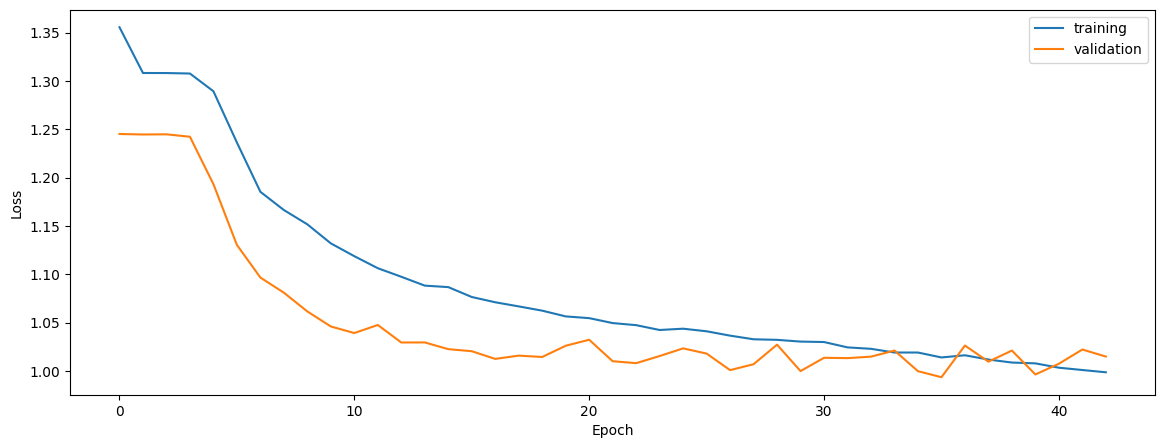

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6424549395391285
0.661440404475043
0.6562322760787052


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.6424549395391285
0.661440404475043
0.6562322760787052


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6392599674427017
0.6588183518538893
0.6608868675383741


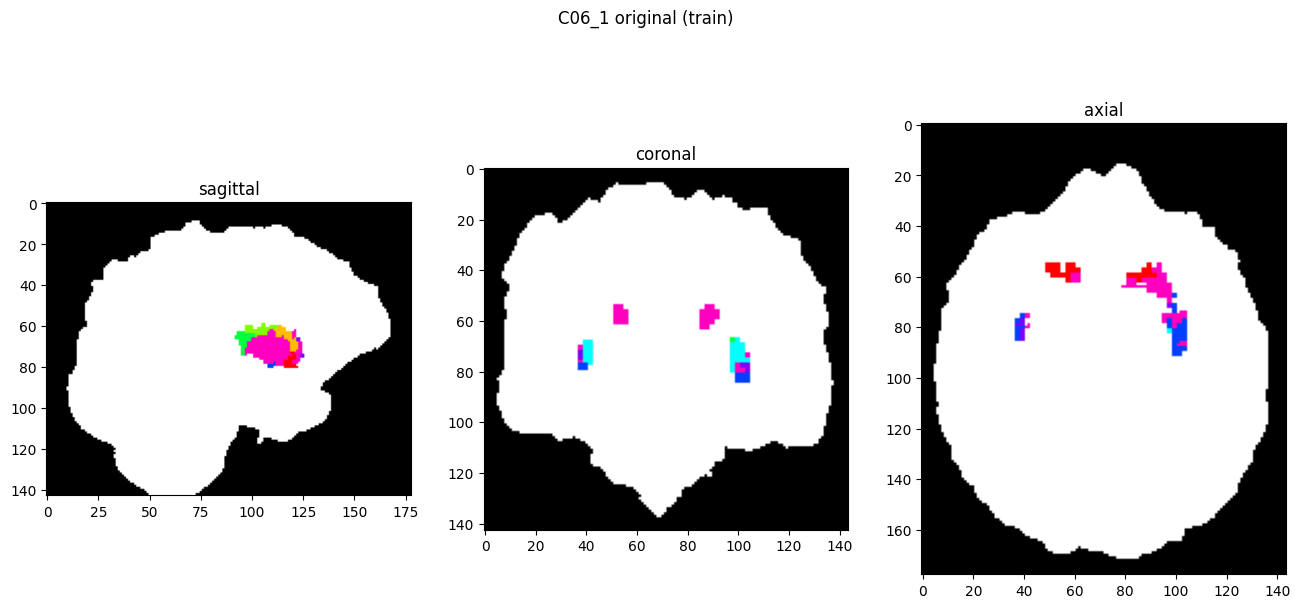

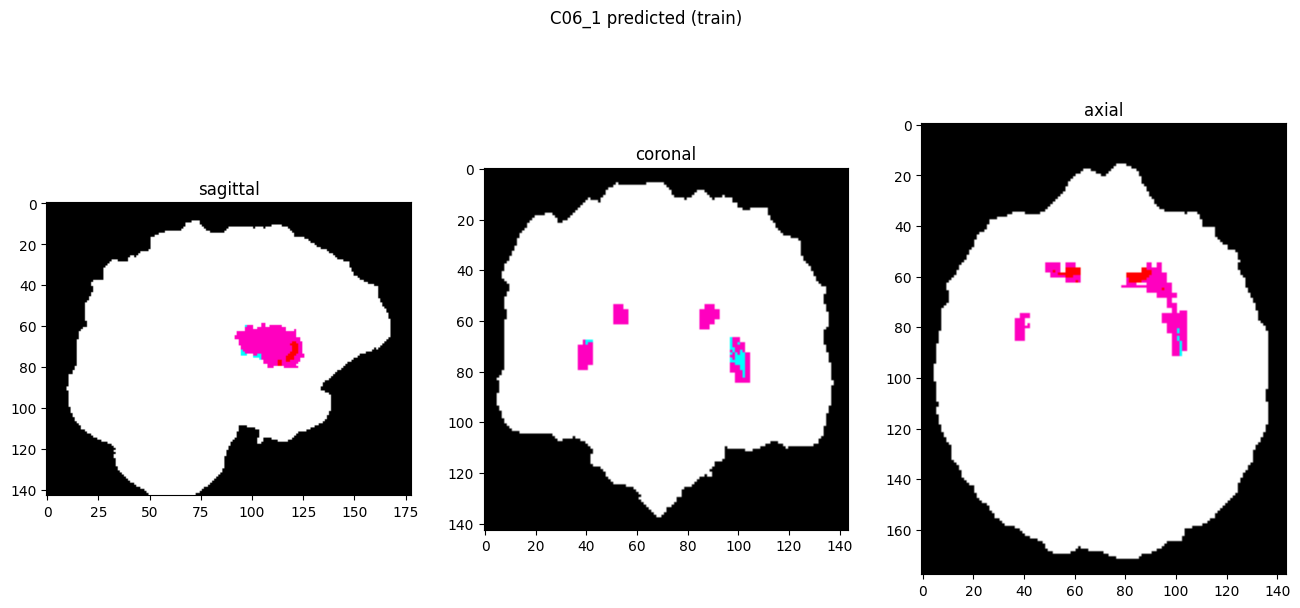

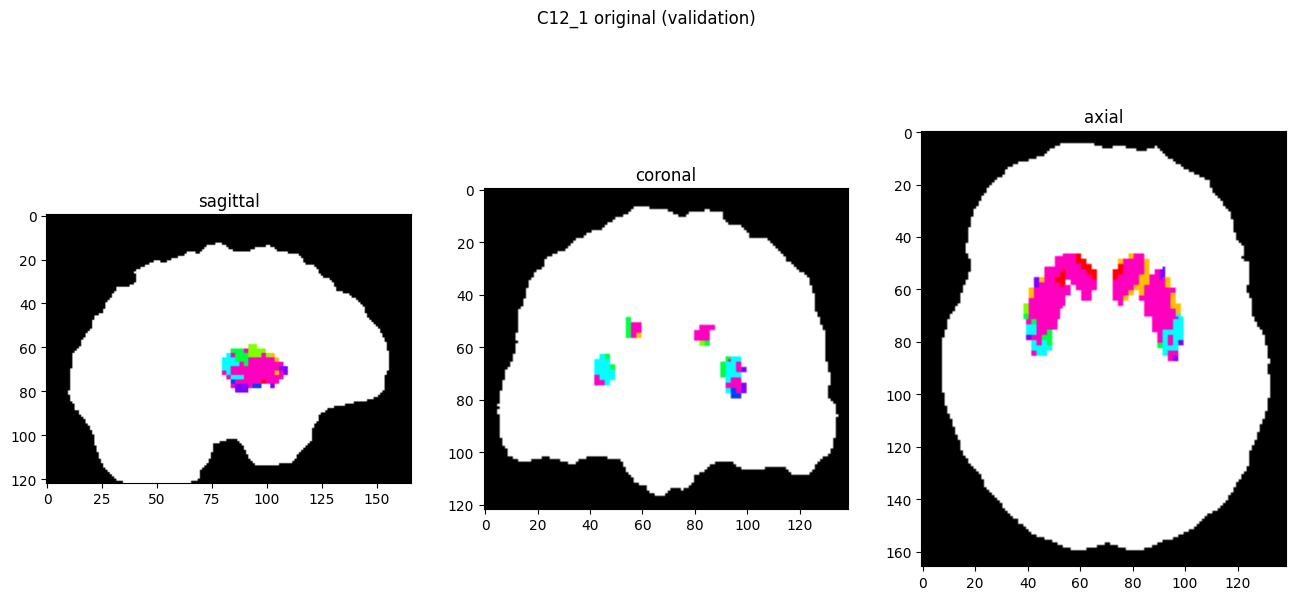

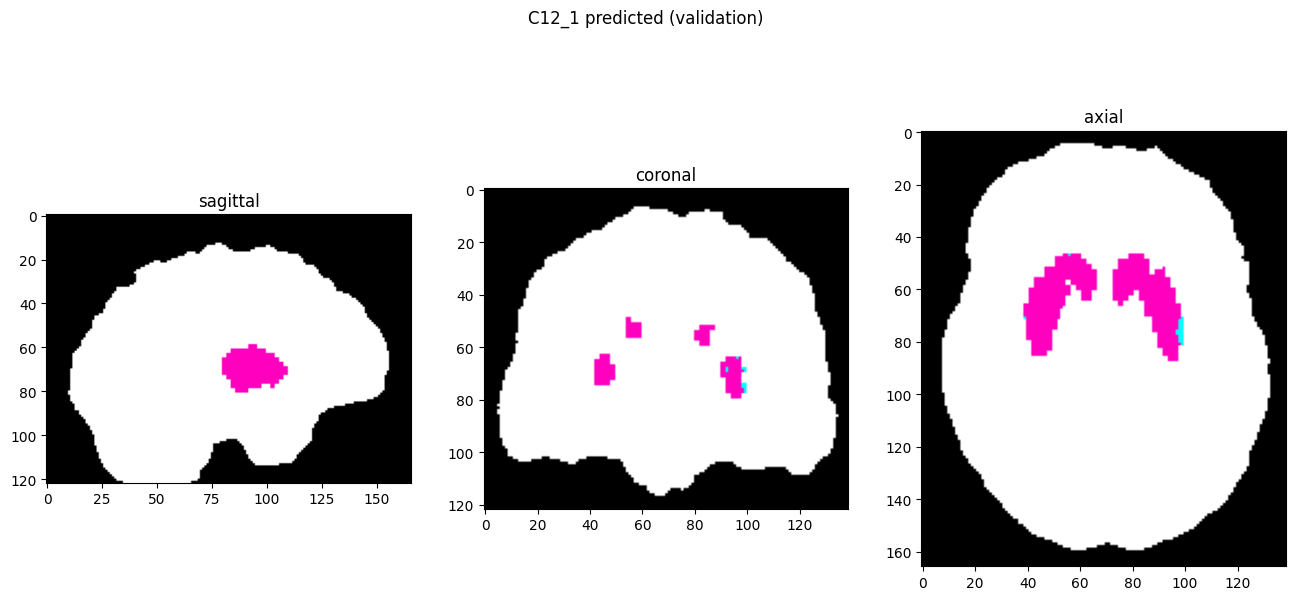

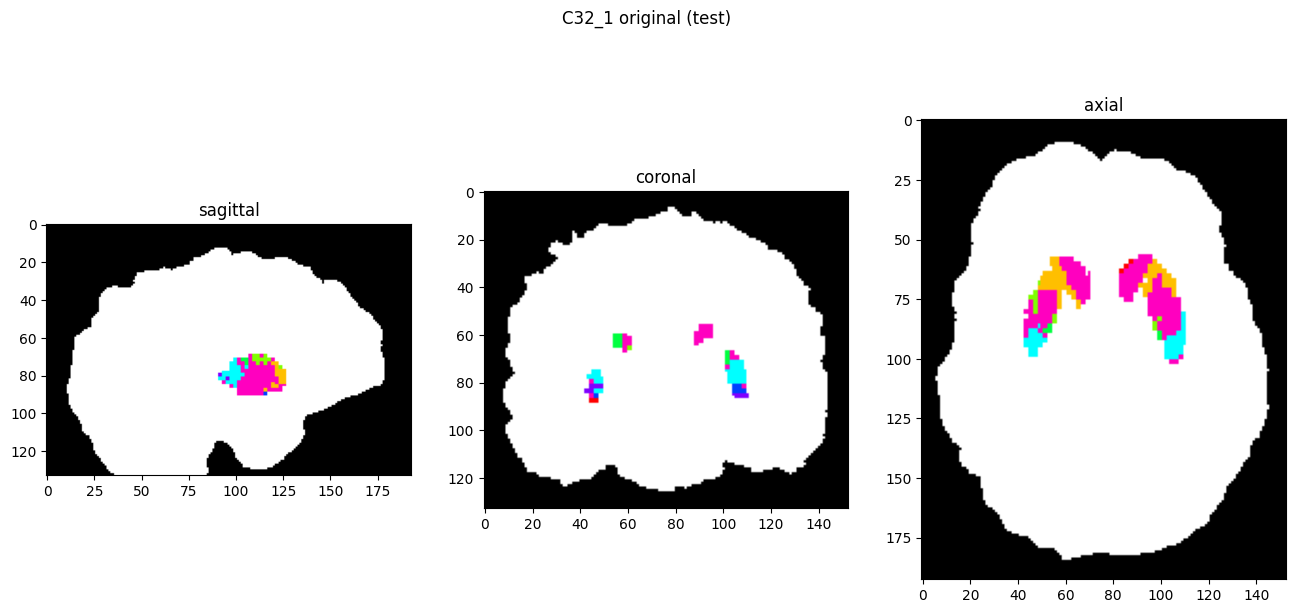

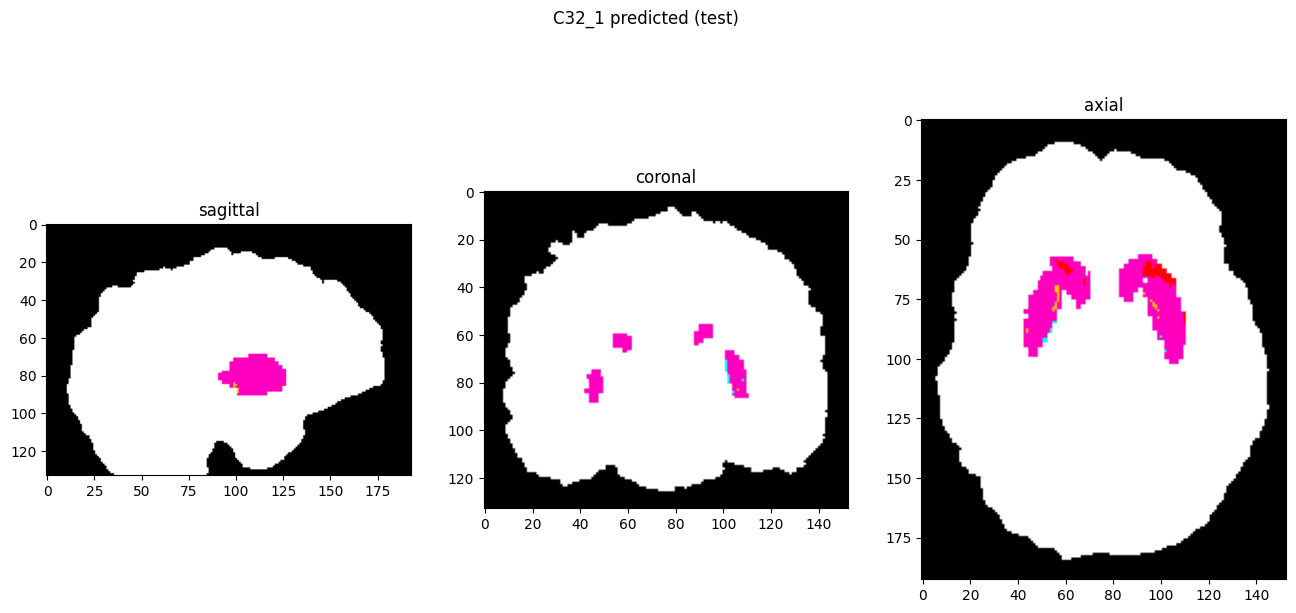

In [10]:
showResults(model, gen, threshold=0)